In [75]:

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import os
import pandas as pd
from time import time
import matplotlib.pyplot as plt
# from binarized_modules import  BinarizeLinear,BinarizeConv2d

In [76]:
import os
os.chdir("/home/earapidis/Desktop/BinaryNet.pytorch")
os.getcwd()

'/home/earapidis/Desktop/BinaryNet.pytorch'

In [77]:
import models.binarized_modules

In [78]:
import importlib
importlib.reload(models.binarized_modules)

<module 'models.binarized_modules' from '/home/earapidis/Desktop/BinaryNet.pytorch/models/binarized_modules.py'>

In [79]:
from models.binarized_modules import  BinarizeLinear,BinarizeConv2d
from models.binarized_modules import  Binarize,HingeLoss


In [80]:
cuda = True

In [81]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [82]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [83]:
test_batch_size=1000

In [84]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [85]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
        
#         self.fc1 = BinarizeLinear(784, 512)
#         self.bn1 = nn.BatchNorm1d(512)
#         self.htanh1 = nn.Hardtanh()

#         self.fc2 = BinarizeLinear(512, 64)
#         self.bn2 = nn.BatchNorm1d(64)
#         self.htanh2 = nn.Hardtanh()

        
#         self.fc3 =BinarizeLinear(64,10)

#         self.drop=nn.Dropout(0.1)

#     def forward(self, x):
#         x = x.view(-1, 28*28)
#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = self.htanh1(x)

#         x = self.drop(x)

#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = self.htanh2(x)
        
#         x = self.drop(x)

#         x = self.fc3(x)
#         return x
#         # return self.logsoftmax(x)

# model = Net()
# if cuda:
#     torch.cuda.set_device(0)
#     model.cuda()


In [86]:
import models.lenet_5


importlib.reload(models.lenet_5)

<module 'models.lenet_5' from '/home/earapidis/Desktop/BinaryNet.pytorch/models/lenet_5.py'>

In [87]:
# from models.lenet_5 import BinarizedLeNet5_NoBN as Net
from models.lenet_5 import BinarizedLeNet5_BN as Net

In [88]:
# from mnist_bnn import Net

model = Net()
# model = Net()
if cuda:
    torch.cuda.set_device(0)
    model.cuda()


In [89]:
lr=0.001

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [91]:
log_interval=100

In [92]:
def train(epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # print(batch_idx)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if epoch%40==0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

        optimizer.zero_grad()
        loss.backward()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-1,1))
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [93]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc = 100. * correct / len(test_loader.dataset)
    return acc

In [94]:
epochs=30

In [95]:
model_sim = 2

save_dir = os.path.abspath("/shares/bulk/earapidis/saved_models/lenet_5")
# save_dir = os.path.abspath("/shares/bulk/earapidis/saved_models")
models_path = os.path.join(save_dir,f"model_{model_sim}")

os.makedirs(models_path,exist_ok=True)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.620768
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.899356
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.709922
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.628535
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.566157
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.331993
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.513983
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.591986
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.455505
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.273841

Test set: Average loss: 0.0003, Accuracy: 9283/10000 (93%)

[2.6207680702209473, 2.272313117980957, 2.4844844341278076, 2.179265022277832, 2.1559336185455322, 2.0662078857421875, 1.6321942806243896, 1.7603620290756226, 1.8159379959106445, 1.6918950080871582, 1.7174217700958252, 1.4952820539474487, 1.4142613410949707, 1.567277193069458, 1.4653491973876953, 1.2846431732177734, 1.4294579029083252, 1.3608081340789795, 1.5135223865509033, 1.4392492771148682, 1.3290379047393799, 1.187972068786621, 1.246608

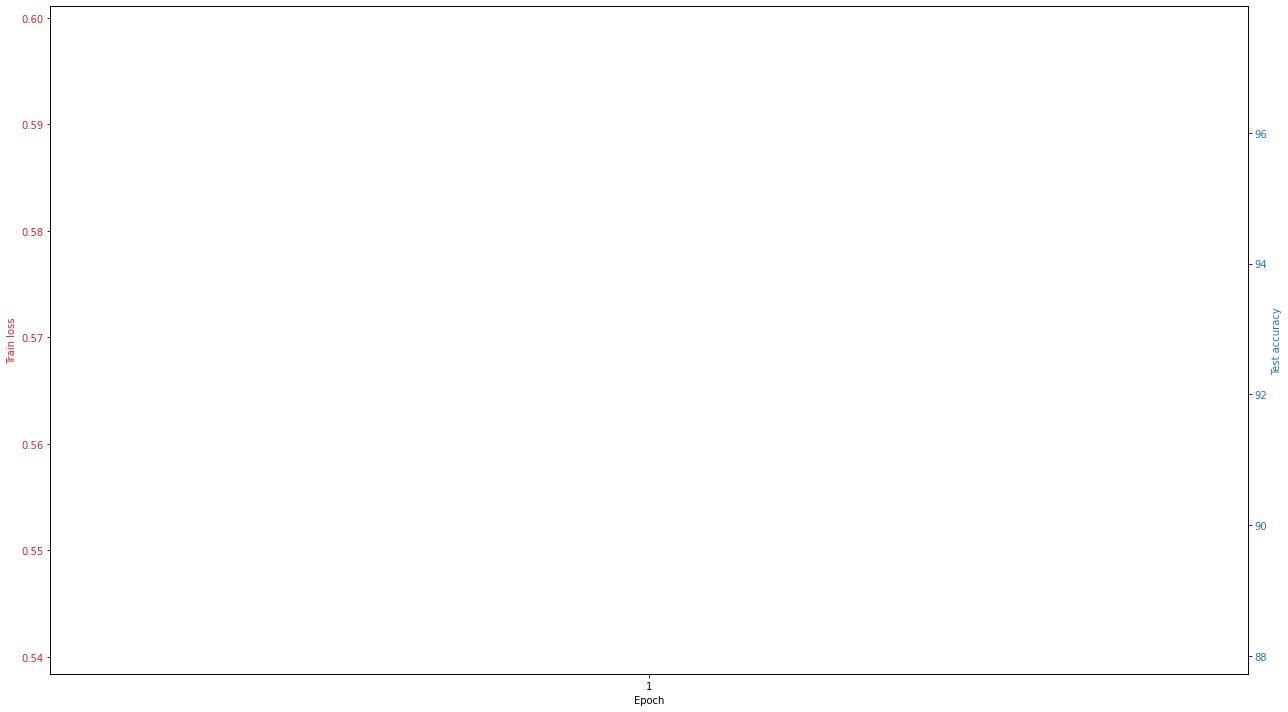

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_1.pth
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.447387
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.233300
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.264968
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.334247
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.299130
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.333802
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.306273
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.200702
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.210792
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.279937

Test set: Average loss: 0.0002, Accuracy: 9443/10000 (94%)

[0.4473867118358612, 0.2408444732427597, 0.4829082190990448, 0.3182867467403412, 0.439540833234787, 0.28093862533569336, 0.42036518454551697, 0.45068803429603577, 0.42066138982772827, 0.3357471227645874, 0.3677927255630493, 0.5060176849365234, 0.33882632851600647, 0.556418240070343, 0.3561061918735504, 0.4429432153701782, 0.32741886377334595, 0.47117969393730164, 0.4

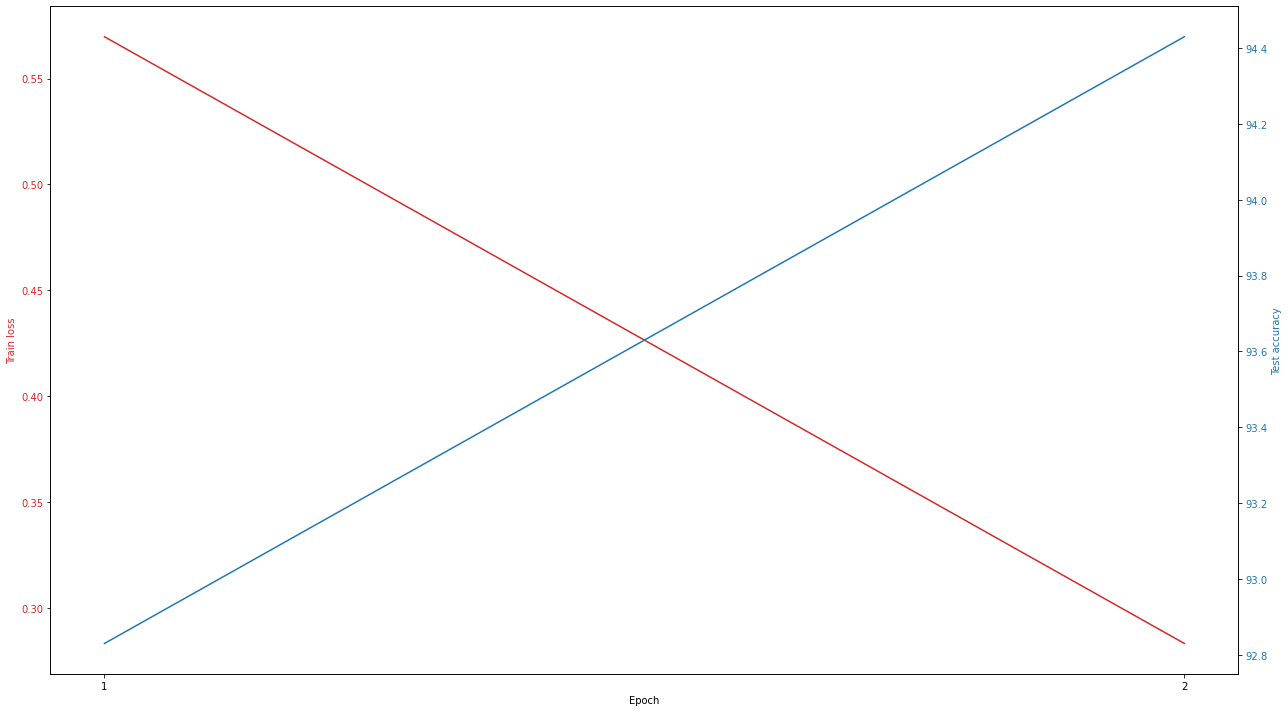

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_2.pth
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.281840
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.311942
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.274971
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.167045
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.173211
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.238313
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.140506
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.088390
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.153578
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.146451

Test set: Average loss: 0.0006, Accuracy: 7943/10000 (79%)

[0.2818397879600525, 0.5433251857757568, 0.27473822236061096, 0.14191454648971558, 0.23968219757080078, 0.3166804313659668, 0.1787252575159073, 0.19847799837589264, 0.21081967651844025, 0.20480138063430786, 0.2668522000312805, 0.15726906061172485, 0.29931870102882385, 0.3152950704097748, 0.20207121968269348, 0.3072417676448822, 0.11400364339351654, 0.2600873112678528

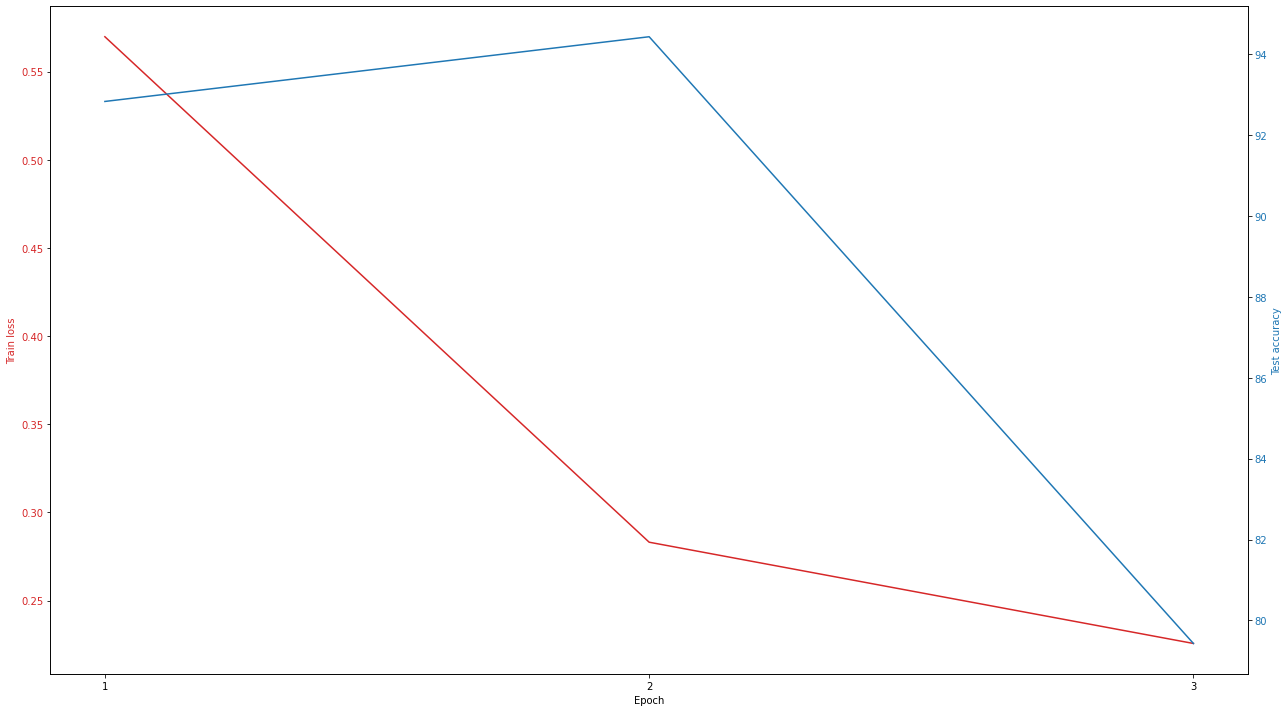

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_3.pth
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.235981
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.128478
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.165543
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.157940
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.307975
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.099661
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.179432
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.250770
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.178780
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.166366

Test set: Average loss: 0.0001, Accuracy: 9629/10000 (96%)

[0.23598124086856842, 0.2637866735458374, 0.11173621565103531, 0.252755343914032, 0.1876697987318039, 0.11226489394903183, 0.41473907232284546, 0.2910882830619812, 0.2567596137523651, 0.3695259690284729, 0.09274140000343323, 0.06624513119459152, 0.2146196812391281, 0.11108005046844482, 0.243862584233284, 0.3311687111854553, 0.21804746985435486, 0.1274365484714508, 0.

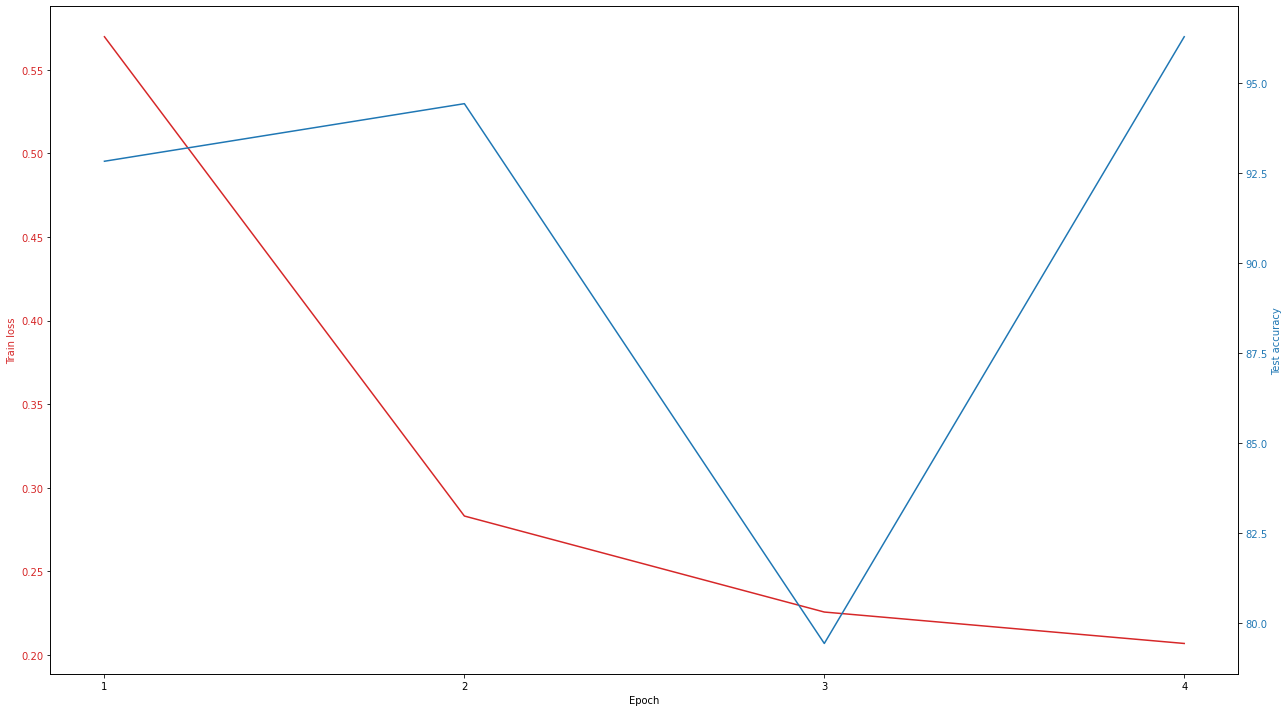

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_4.pth
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.202689
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.220783
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.214521
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.095277
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.238104
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.095728
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.241006
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.382071
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.199780
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.270046

Test set: Average loss: 0.0001, Accuracy: 9584/10000 (96%)

[0.20268870890140533, 0.1594075709581375, 0.09488978981971741, 0.13781440258026123, 0.1391226351261139, 0.21007221937179565, 0.0819489136338234, 0.15181244909763336, 0.19461749494075775, 0.2050405740737915, 0.10280856490135193, 0.26352909207344055, 0.2690882682800293, 0.2041155993938446, 0.28565260767936707, 0.19575509428977966, 0.21607272326946259, 0.217636033892631

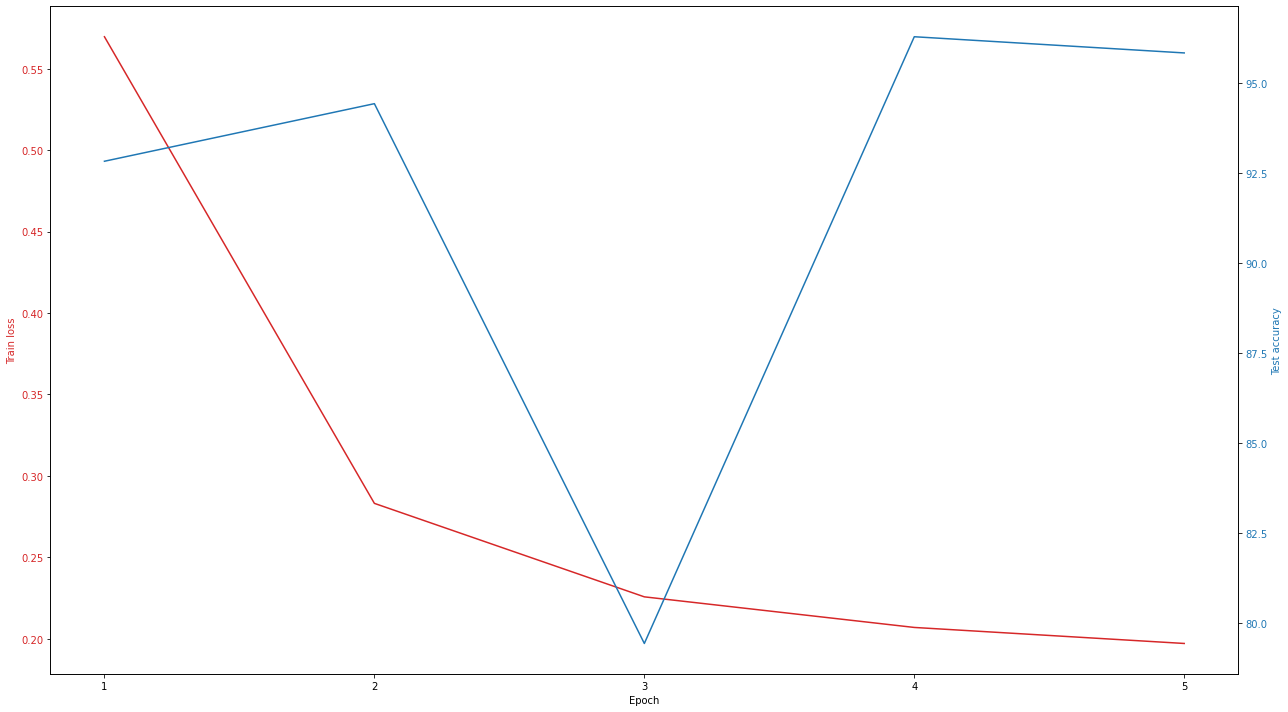

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_5.pth
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.267077
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.214768
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.329726
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.230659
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.306411
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.171536
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.115683
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.336041
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.227422
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.228345

Test set: Average loss: 0.0001, Accuracy: 9568/10000 (96%)

[0.26707687973976135, 0.1898629516363144, 0.34383150935173035, 0.11882918328046799, 0.30072927474975586, 0.09125808626413345, 0.12984290719032288, 0.08192252367734909, 0.13041608035564423, 0.14995256066322327, 0.15244606137275696, 0.28198105096817017, 0.24556326866149902, 0.14998038113117218, 0.22319337725639343, 0.0956006795167923, 0.2703426778316498, 0.149391621351

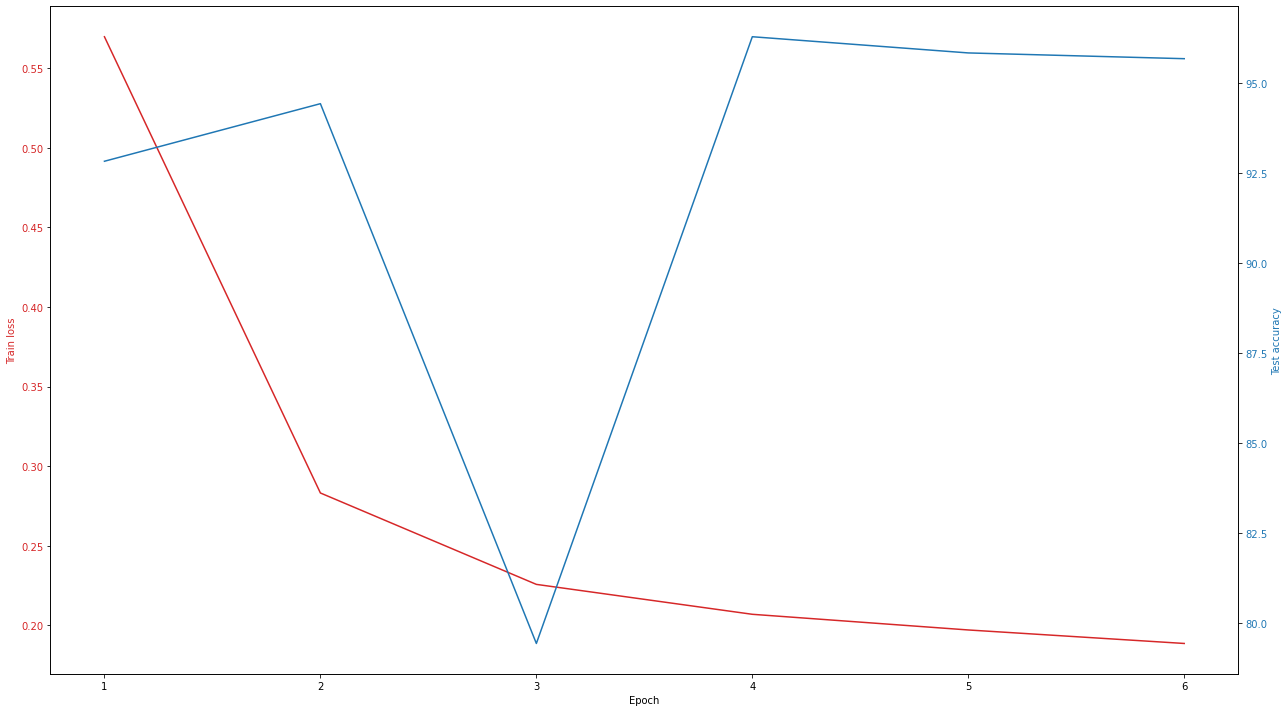

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_6.pth
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.113890
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.278246
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.254987
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.184293
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.178905
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.394418
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.192422
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.277520
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.063188
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.333540

Test set: Average loss: 0.0001, Accuracy: 9601/10000 (96%)

[0.11389042437076569, 0.2573959231376648, 0.11098018288612366, 0.2773204445838928, 0.4351471960544586, 0.16399505734443665, 0.09425569325685501, 0.4099428951740265, 0.07935462146997452, 0.201694056391716, 0.1623646318912506, 0.1994231790304184, 0.1155594065785408, 0.1817881017923355, 0.1864015907049179, 0.2029842734336853, 0.19181574881076813, 0.17216140031814575, 0.

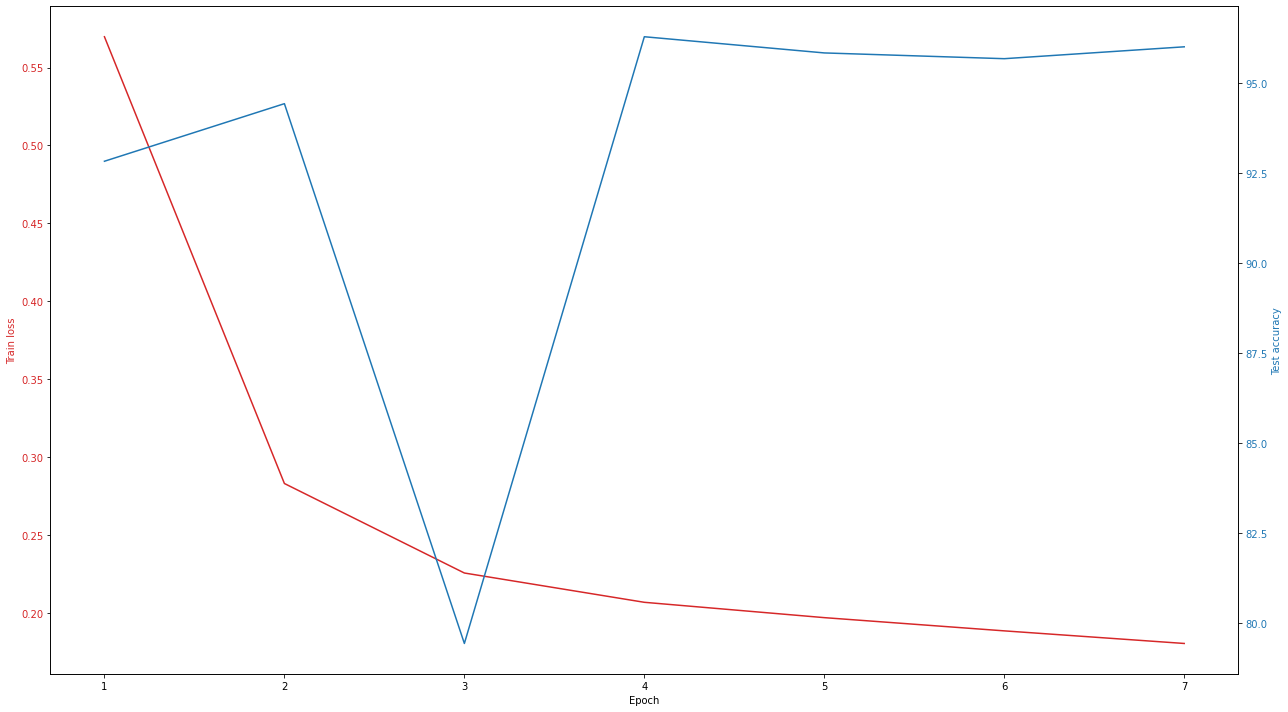

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_7.pth
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.191320
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.140263
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.258341
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.122413
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.217518
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.233465
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.224528
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.236220
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.122543
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.213073

Test set: Average loss: 0.0003, Accuracy: 9181/10000 (92%)

[0.19132006168365479, 0.11277513206005096, 0.071042001247406, 0.08910570293664932, 0.1312406212091446, 0.061950843781232834, 0.3373284339904785, 0.18051078915596008, 0.10865949839353561, 0.18943685293197632, 0.21606631577014923, 0.09168606996536255, 0.1580609381198883, 0.18253007531166077, 0.12056754529476166, 0.11585217714309692, 0.06538042426109314, 0.1696432232856

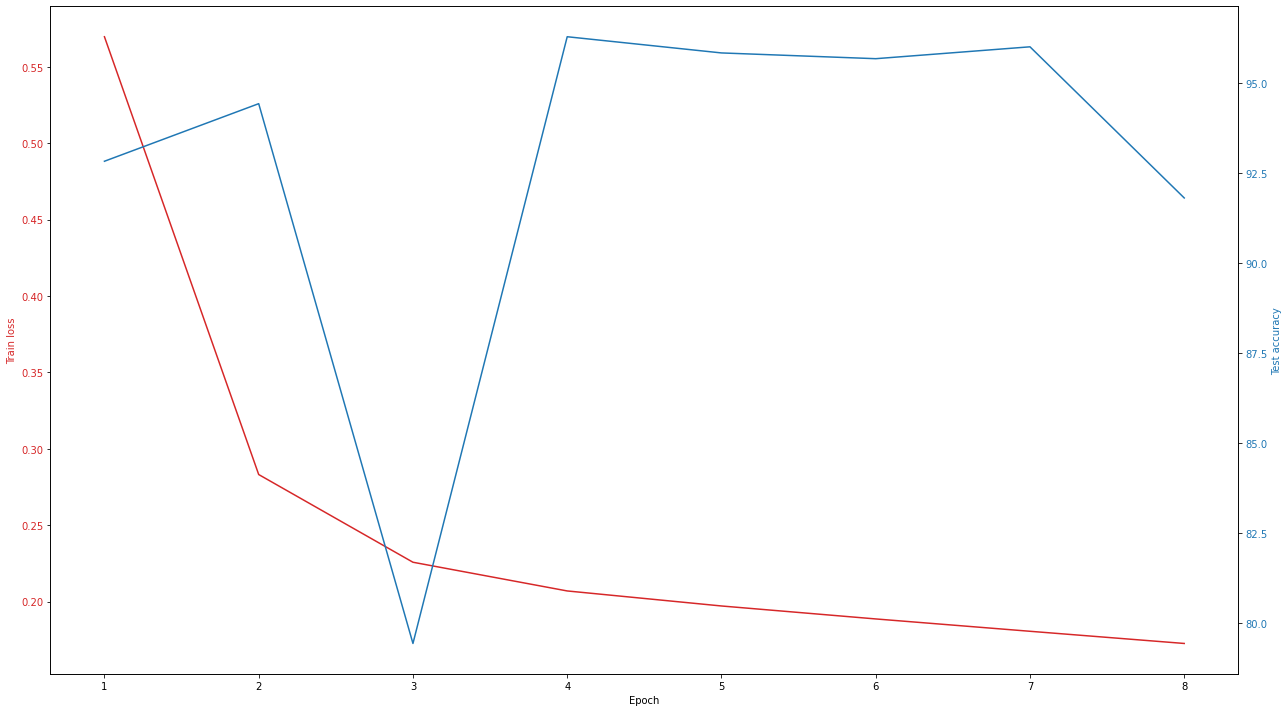

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_8.pth
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.163496
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.064292
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.218805
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.095012
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.251372
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.173269
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.125580
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.127818
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.149870
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.103342

Test set: Average loss: 0.0001, Accuracy: 9650/10000 (96%)

[0.16349615156650543, 0.11884555220603943, 0.27747979760169983, 0.23513054847717285, 0.329378217458725, 0.23242977261543274, 0.20447859168052673, 0.09314694255590439, 0.15002374351024628, 0.10931424051523209, 0.07593194395303726, 0.10019854456186295, 0.17963933944702148, 0.09861933439970016, 0.10801852494478226, 0.15376326441764832, 0.4153546392917633, 0.140448629856

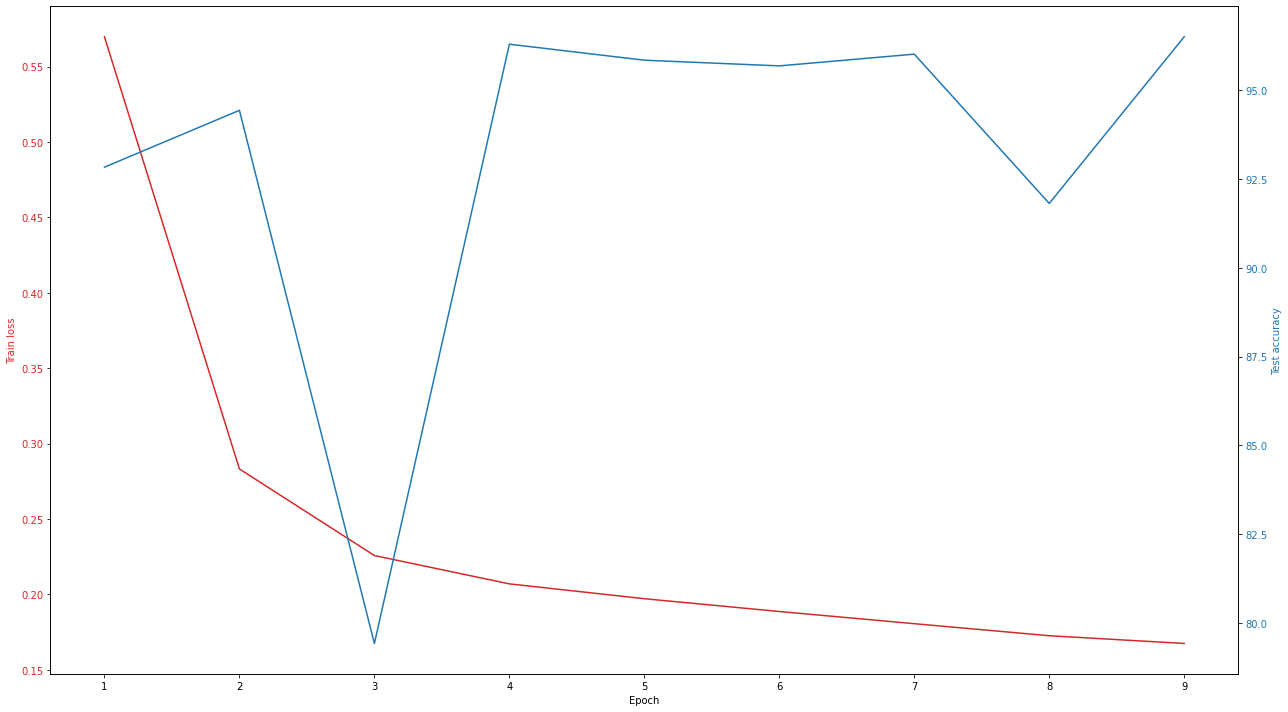

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_9.pth
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.243421
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.169224
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.125060
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.134265
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.077775
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.185524
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.133555
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.065958
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.232565
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.134930

Test set: Average loss: 0.0001, Accuracy: 9606/10000 (96%)

[0.24342091381549835, 0.21015681326389313, 0.14651384949684143, 0.11038652807474136, 0.48309898376464844, 0.04531383886933327, 0.08221212774515152, 0.13397589325904846, 0.16791768372058868, 0.054391033947467804, 0.13220791518688202, 0.12956318259239197, 0.1635216623544693, 0.4948289692401886, 0.17381340265274048, 0.11068025231361389, 0.24093419313430786, 0.

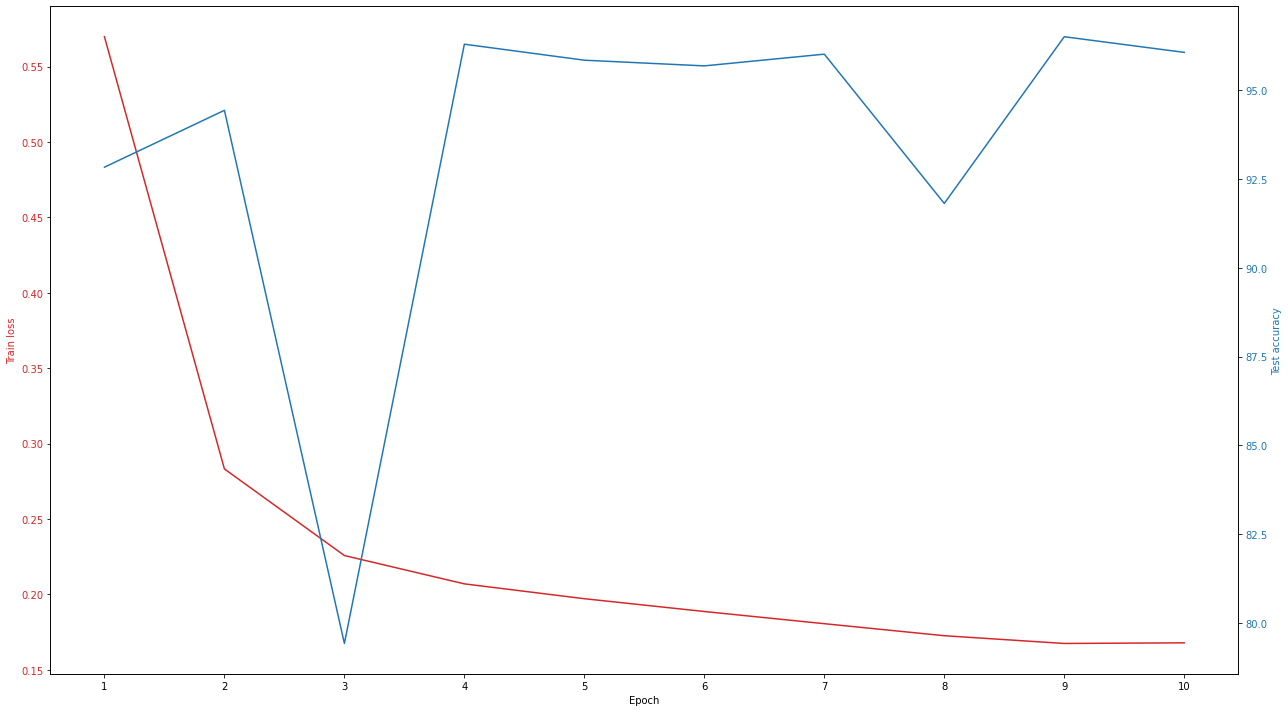

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_10.pth
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.092706
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.122832
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.193689
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.082227
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.180967
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.117539
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.260110
Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.113782
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.118876
Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.120561

Test set: Average loss: 0.0004, Accuracy: 8898/10000 (89%)

[0.09270570427179337, 0.14248597621917725, 0.1679191291332245, 0.0963478684425354, 0.06968449801206589, 0.2079370617866516, 0.25265344977378845, 0.2829025685787201, 0.22308489680290222, 0.22625339031219482, 0.16432073712348938, 0.06532218307256699, 0.2378281205892563, 0.20241953432559967, 0.038987722247838974, 0.1549912989139557, 0.4054771959781647, 0.0316

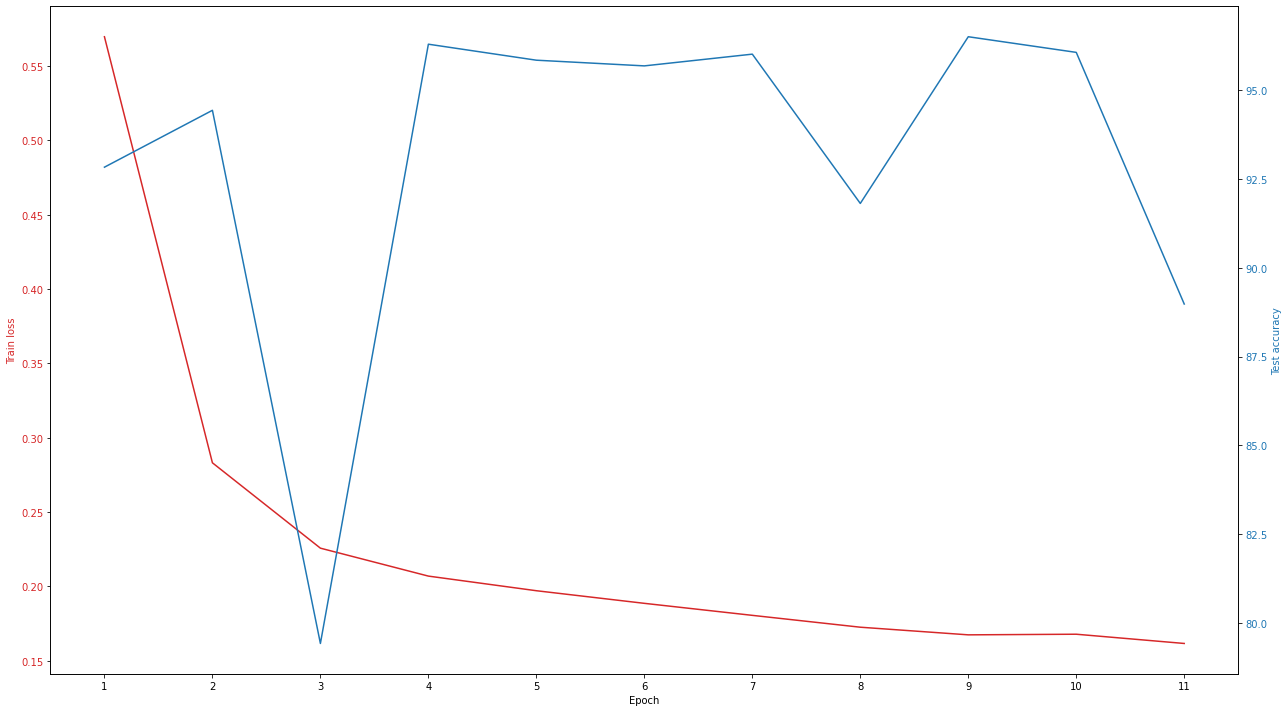

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_11.pth
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.333388
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.119577
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.381875
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.130074
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.085014
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.059337
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.128526
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.105121
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.170456
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.242286

Test set: Average loss: 0.0001, Accuracy: 9600/10000 (96%)

[0.3333876430988312, 0.05033525824546814, 0.22414469718933105, 0.1017305850982666, 0.31389737129211426, 0.06916869431734085, 0.17469094693660736, 0.48396700620651245, 0.12809394299983978, 0.041137561202049255, 0.20270998775959015, 0.21019937098026276, 0.17848213016986847, 0.08641186356544495, 0.20131690800189972, 0.13959670066833496, 0.269755095243454, 0.0

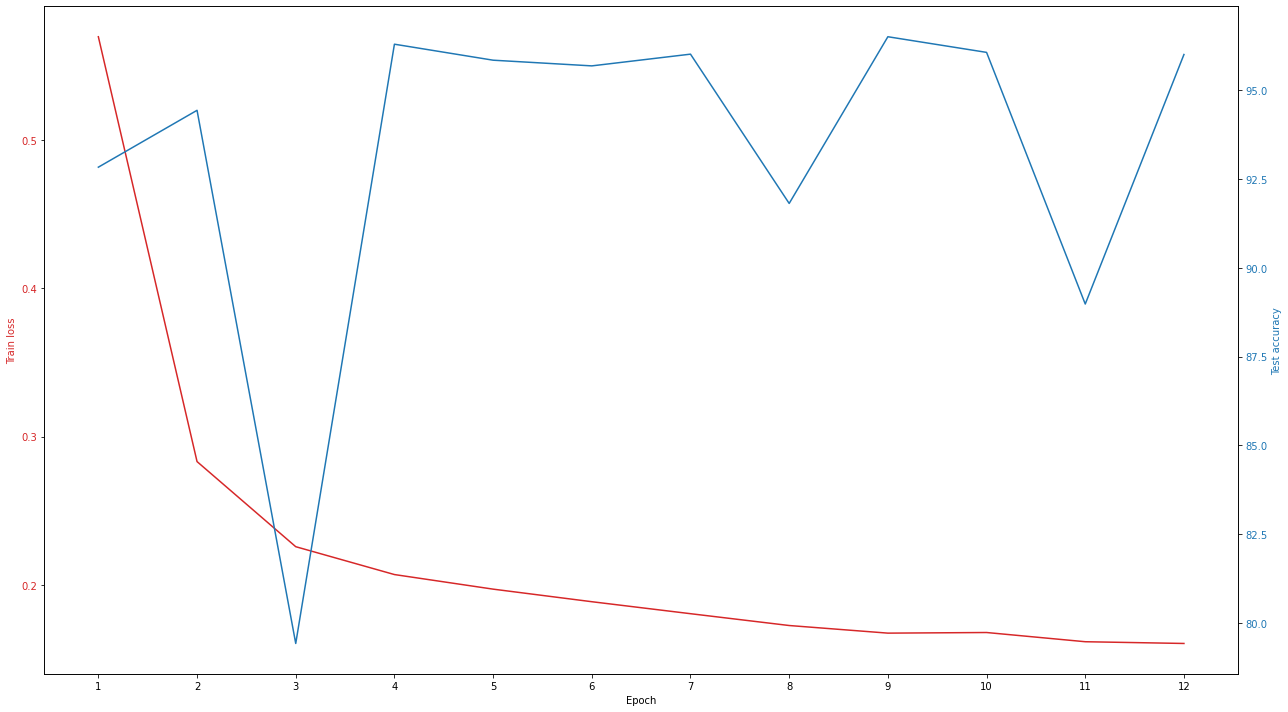

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_12.pth
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.134655
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.073575
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.109108
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.140633
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.160051
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.065325
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.086864
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.198615
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.301985
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.157732

Test set: Average loss: 0.0001, Accuracy: 9678/10000 (97%)

[0.13465456664562225, 0.16274292767047882, 0.11375366896390915, 0.15913642942905426, 0.04718826338648796, 0.17129267752170563, 0.17747339606285095, 0.21747608482837677, 0.09245724976062775, 0.1262248456478119, 0.0985272154211998, 0.12366674095392227, 0.22515738010406494, 0.12684933841228485, 0.3938119411468506, 0.18910428881645203, 0.09406502544879913, 0.0

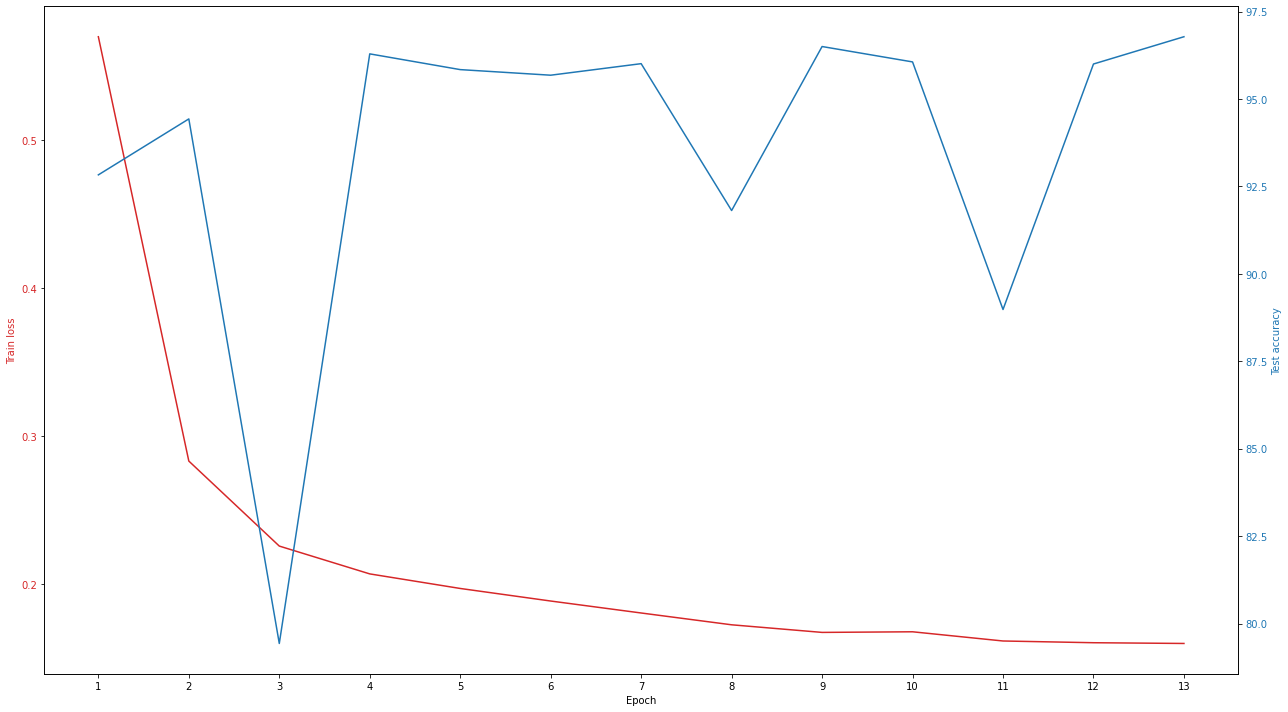

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_13.pth
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.125113
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.220135
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.095736
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.349408
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.385448
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.096644
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.171158
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.091450
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.172446
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.055682

Test set: Average loss: 0.0001, Accuracy: 9625/10000 (96%)

[0.12511329352855682, 0.16913971304893494, 0.08180698752403259, 0.24942973256111145, 0.1451319307088852, 0.10890036821365356, 0.12217190861701965, 0.1809300184249878, 0.1051386147737503, 0.17888619005680084, 0.12647950649261475, 0.1820378303527832, 0.16877248883247375, 0.05905597656965256, 0.13981062173843384, 0.05825641751289368, 0.07551048696041107, 0.03

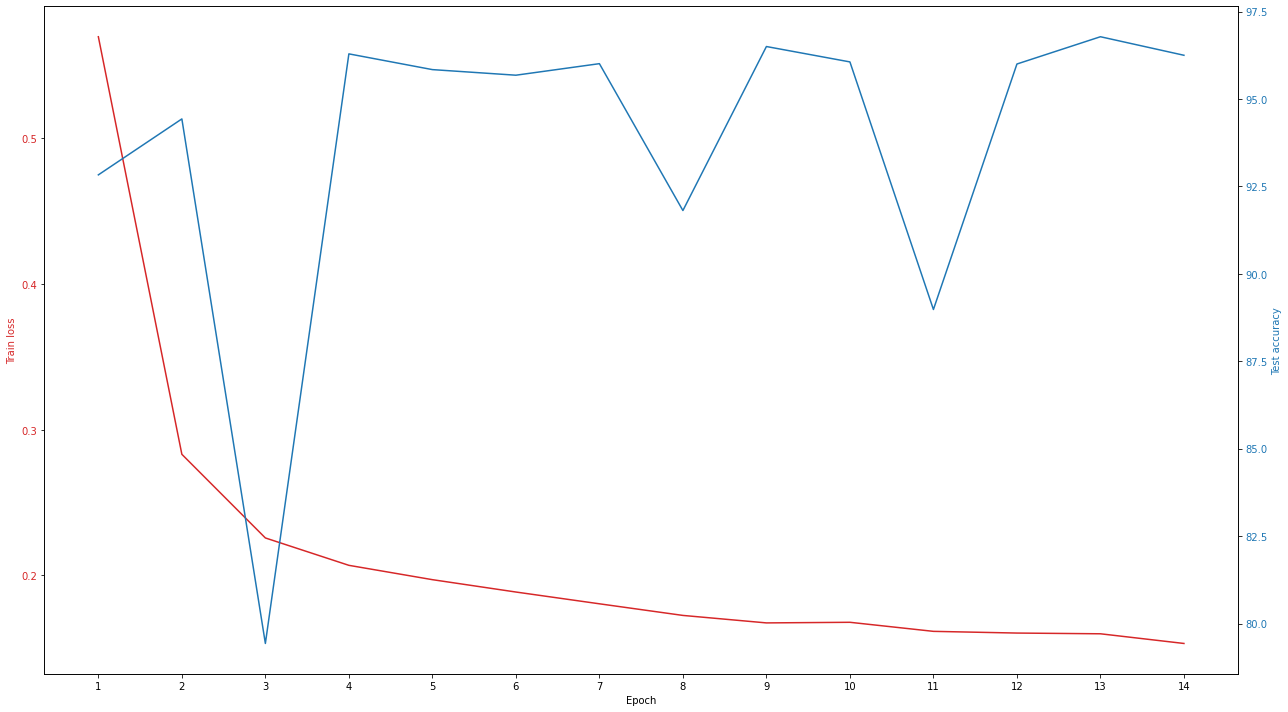

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_14.pth
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.046454
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.123174
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.155882
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.135979
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.142777
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.107434
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.108610
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.166117
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.354824
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.101292

Test set: Average loss: 0.0001, Accuracy: 9712/10000 (97%)

[0.04645390808582306, 0.3434835970401764, 0.10190892964601517, 0.08960414677858353, 0.24952363967895508, 0.03584851324558258, 0.29656970500946045, 0.10697709023952484, 0.061914730817079544, 0.30408042669296265, 0.06398295611143112, 0.0935271829366684, 0.26407790184020996, 0.16135580837726593, 0.07900537550449371, 0.06890711933374405, 0.08780995011329651, 0

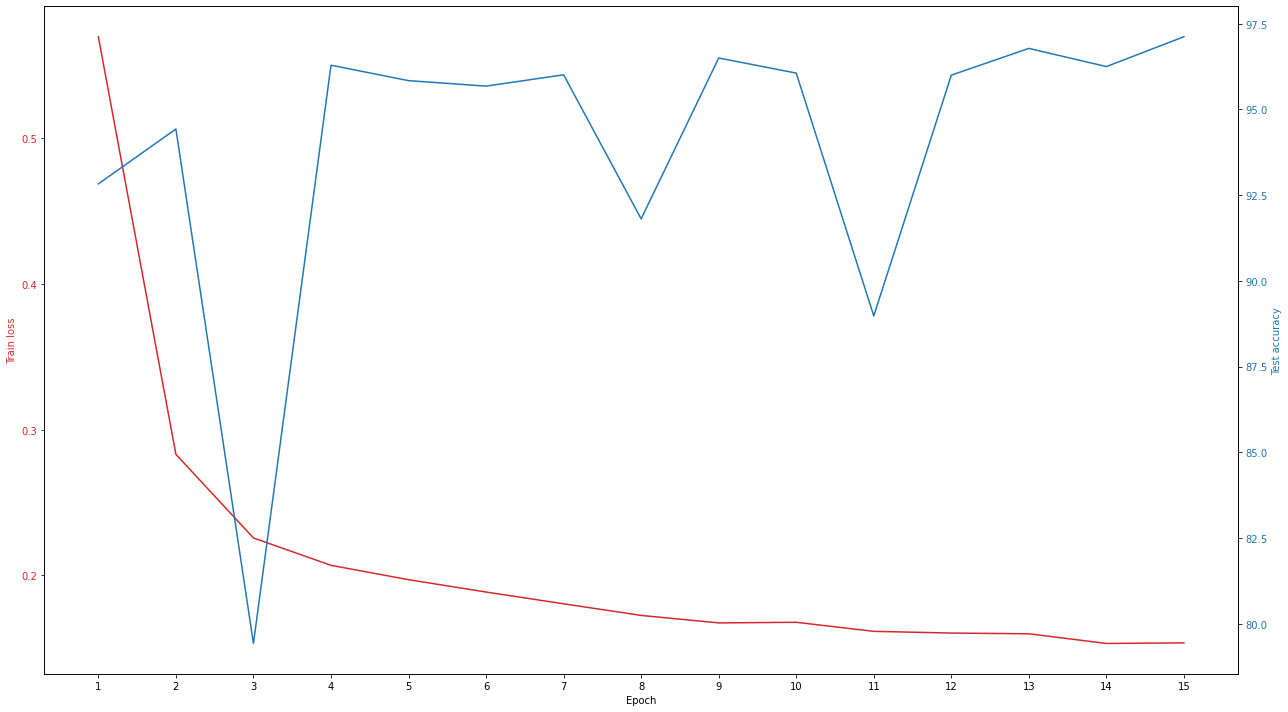

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_15.pth
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.193760
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.237581
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.219870
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.063962
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.150671
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.171240
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.065787
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.089873
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.229248
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.157816

Test set: Average loss: 0.0001, Accuracy: 9647/10000 (96%)

[0.19376008212566376, 0.13531111180782318, 0.05511028692126274, 0.1277114748954773, 0.0579652413725853, 0.07488876581192017, 0.13280457258224487, 0.27386078238487244, 0.22355668246746063, 0.19217681884765625, 0.35360008478164673, 0.048151325434446335, 0.11730208992958069, 0.09537782520055771, 0.03902846574783325, 0.2693951427936554, 0.033062826842069626, 0

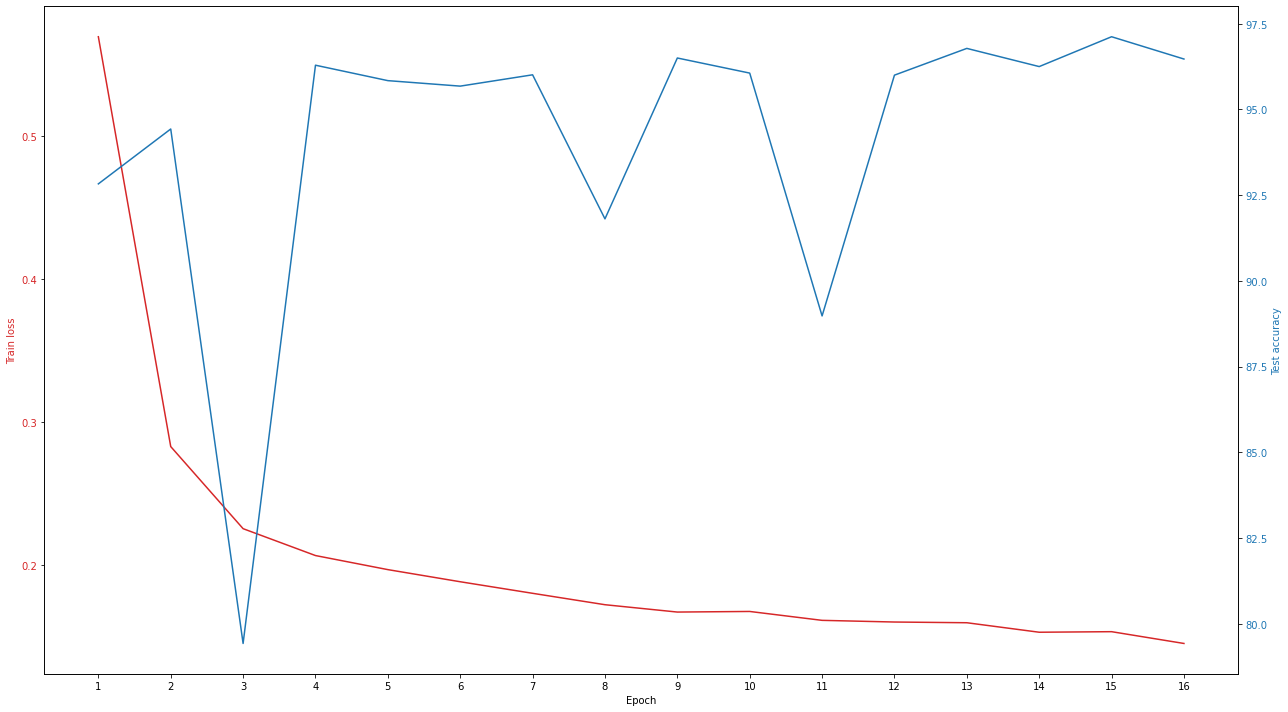

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_16.pth
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.209856
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.326678
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.081084
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.317705
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.172733
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.095358
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.218923
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.204063
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.085868
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.035128

Test set: Average loss: 0.0002, Accuracy: 9474/10000 (95%)

[0.2098562866449356, 0.08870656788349152, 0.18156608939170837, 0.06559628993272781, 0.19237516820430756, 0.08050639927387238, 0.10903418064117432, 0.19819511473178864, 0.05171507969498634, 0.2945915162563324, 0.27117159962654114, 0.0986102968454361, 0.16616389155387878, 0.16559693217277527, 0.22362440824508667, 0.0429842472076416, 0.20075541734695435, 0.14

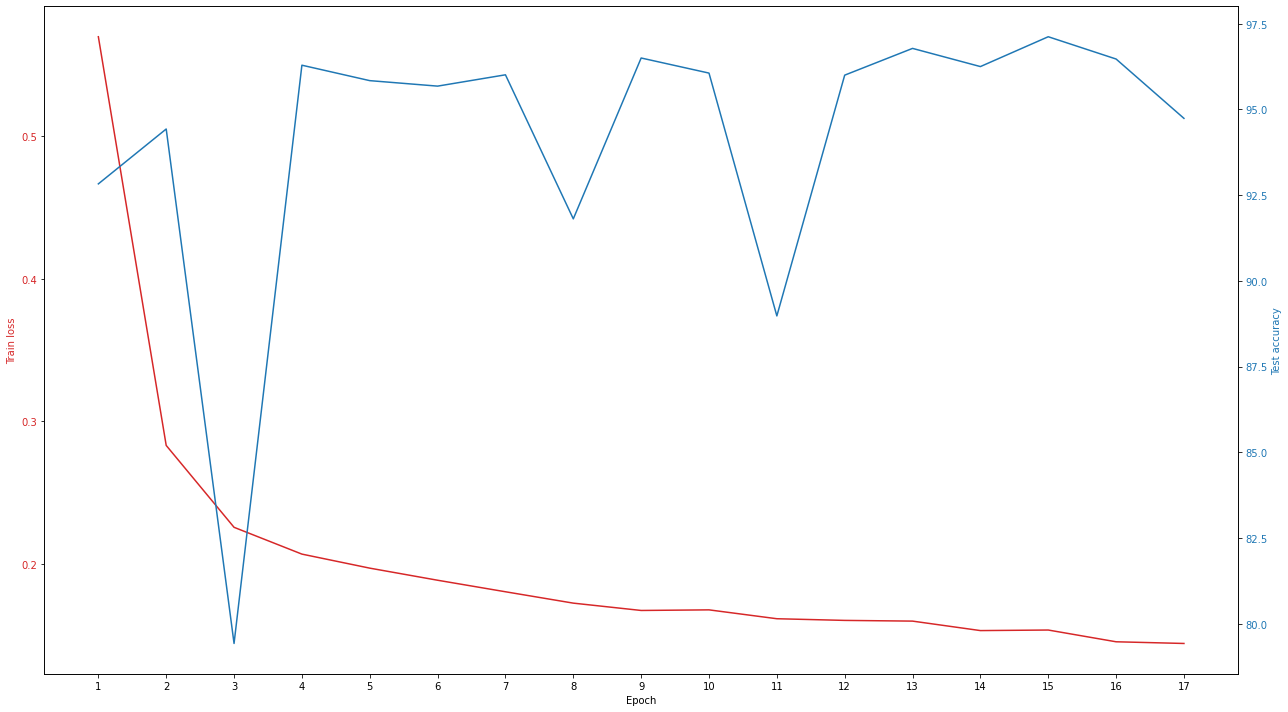

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_17.pth
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.244436
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.156013
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.123576
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.016819
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.115170
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.253338
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.069216
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.147489
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.177237
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.055199

Test set: Average loss: 0.0001, Accuracy: 9586/10000 (96%)

[0.24443626403808594, 0.06625185906887054, 0.1444886028766632, 0.1327923983335495, 0.03588588908314705, 0.19176557660102844, 0.1572282314300537, 0.07340461015701294, 0.12395583838224411, 0.17778782546520233, 0.13676713407039642, 0.12062917649745941, 0.18317899107933044, 0.2192908078432083, 0.12043633311986923, 0.07684991508722305, 0.07984121143817902, 0.06

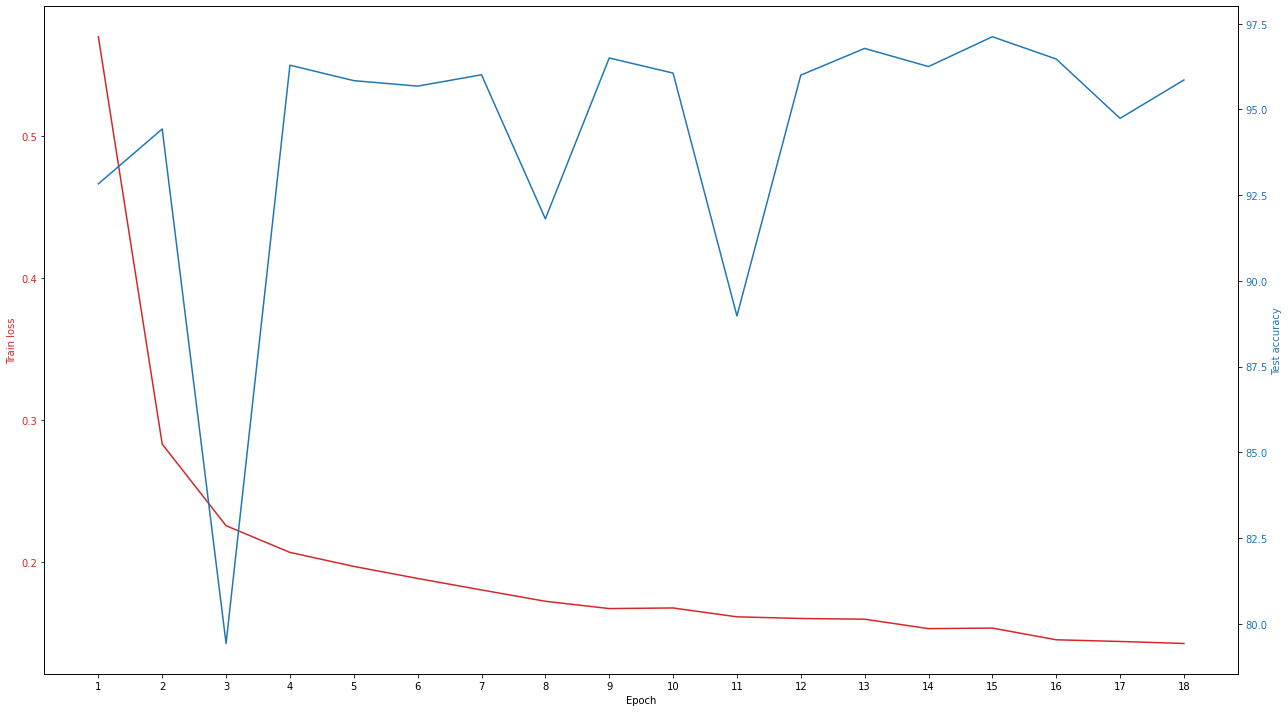

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_18.pth
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.088318
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.111148
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.153430
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.085170
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.150125
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.047579
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.093532
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.289380
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.285691
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.074038

Test set: Average loss: 0.0001, Accuracy: 9660/10000 (97%)

[0.08831760287284851, 0.1315167397260666, 0.2178652137517929, 0.06789252907037735, 0.10511228442192078, 0.105367511510849, 0.20041589438915253, 0.056720834225416183, 0.1903238147497177, 0.05546984449028969, 0.1007297933101654, 0.2184860110282898, 0.08494780212640762, 0.08406642824411392, 0.183511883020401, 0.35482293367385864, 0.10655073821544647, 0.061031

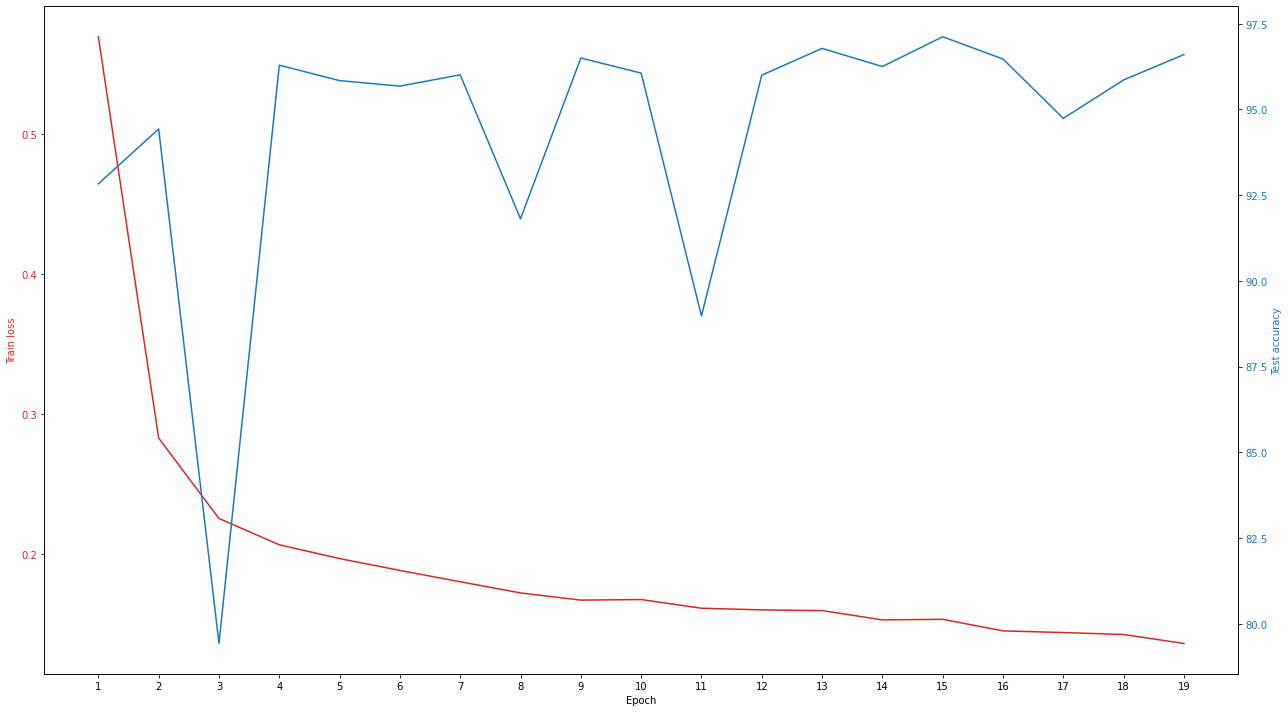

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_19.pth
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.242505
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.063521
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.062674
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.071611
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.169838
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.126825
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.081809
Train Epoch: 20 [44800/60000 (75%)]	Loss: 0.073495
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.043810
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.195092

Test set: Average loss: 0.0001, Accuracy: 9555/10000 (96%)

[0.24250470101833344, 0.1244092732667923, 0.05560985207557678, 0.062452878803014755, 0.4363790452480316, 0.05235385149717331, 0.08429578691720963, 0.18538744747638702, 0.09715422242879868, 0.10566795617341995, 0.18892328441143036, 0.15023526549339294, 0.08512978255748749, 0.03819270059466362, 0.024077503010630608, 0.09461367875337601, 0.20004959404468536, 

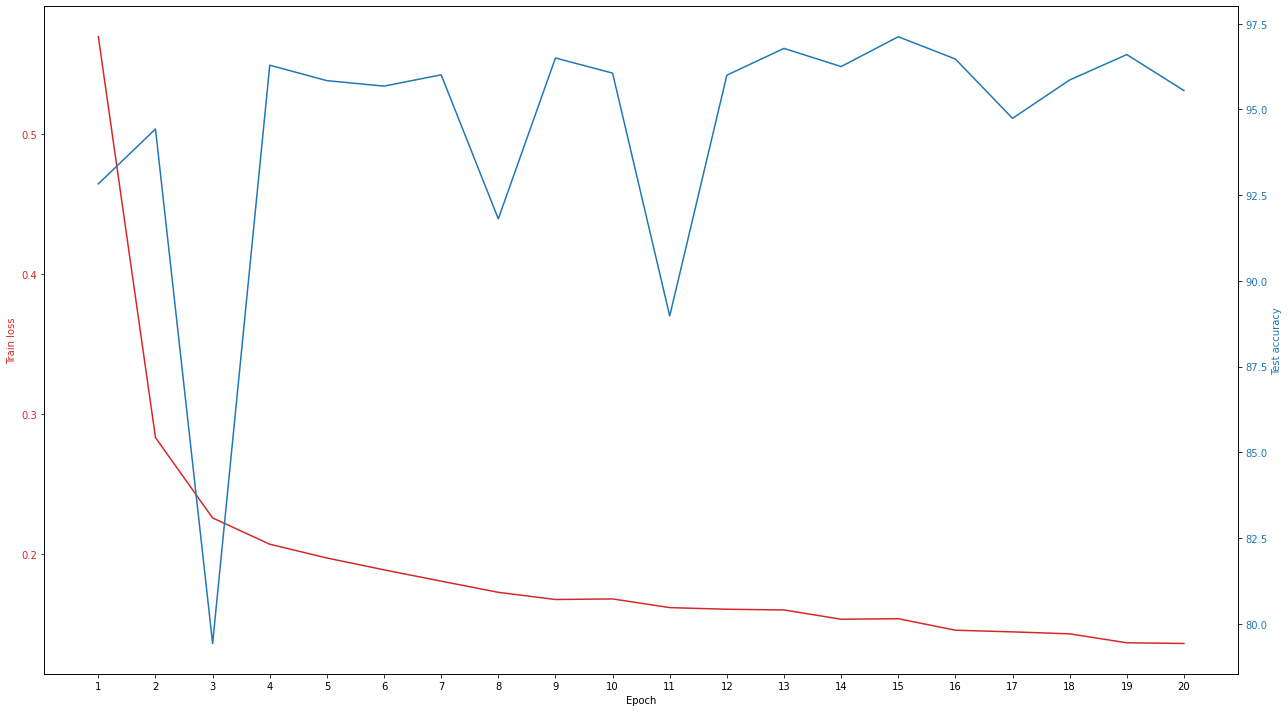

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_20.pth
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.131119
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.032803
Train Epoch: 21 [12800/60000 (21%)]	Loss: 0.170086
Train Epoch: 21 [19200/60000 (32%)]	Loss: 0.099815
Train Epoch: 21 [25600/60000 (43%)]	Loss: 0.104949
Train Epoch: 21 [32000/60000 (53%)]	Loss: 0.055618
Train Epoch: 21 [38400/60000 (64%)]	Loss: 0.021257
Train Epoch: 21 [44800/60000 (75%)]	Loss: 0.113648
Train Epoch: 21 [51200/60000 (85%)]	Loss: 0.160419
Train Epoch: 21 [57600/60000 (96%)]	Loss: 0.016987

Test set: Average loss: 0.0002, Accuracy: 9306/10000 (93%)

[0.13111881911754608, 0.11054051667451859, 0.0948297455906868, 0.2208205759525299, 0.12566299736499786, 0.23757192492485046, 0.12081931531429291, 0.29002341628074646, 0.09619773924350739, 0.09446849673986435, 0.07055822014808655, 0.13630656898021698, 0.16230469942092896, 0.10910257697105408, 0.1090373769402504, 0.05066061019897461, 0.09056442975997925, 0.0

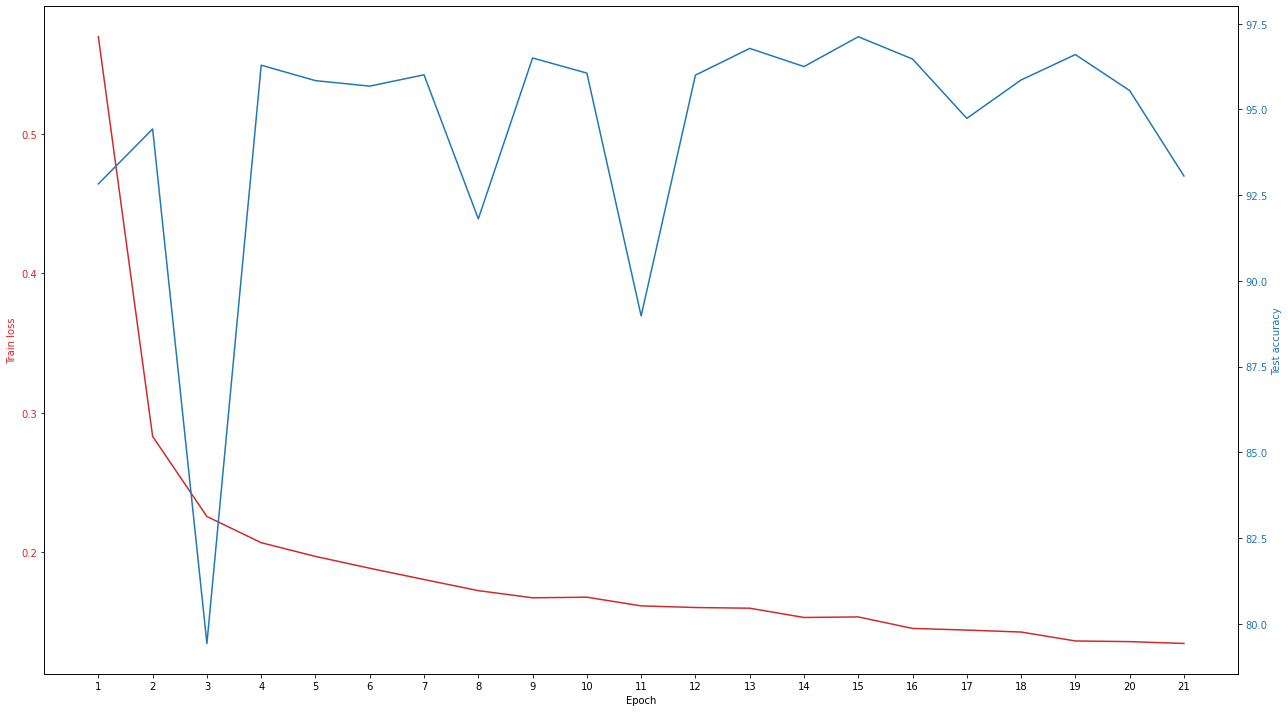

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_21.pth
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.071604
Train Epoch: 22 [6400/60000 (11%)]	Loss: 0.158103
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.109385
Train Epoch: 22 [19200/60000 (32%)]	Loss: 0.257753
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.249287
Train Epoch: 22 [32000/60000 (53%)]	Loss: 0.030258
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.120461
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.182954
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.168984
Train Epoch: 22 [57600/60000 (96%)]	Loss: 0.098698

Test set: Average loss: 0.0001, Accuracy: 9666/10000 (97%)

[0.07160352915525436, 0.21315845847129822, 0.1067451760172844, 0.13303087651729584, 0.0896434411406517, 0.061560411006212234, 0.08230569213628769, 0.2935475707054138, 0.13604646921157837, 0.1256442815065384, 0.12129039317369461, 0.12408389151096344, 0.08608987182378769, 0.06231849268078804, 0.4211667776107788, 0.10970867425203323, 0.10044834017753601, 0.19

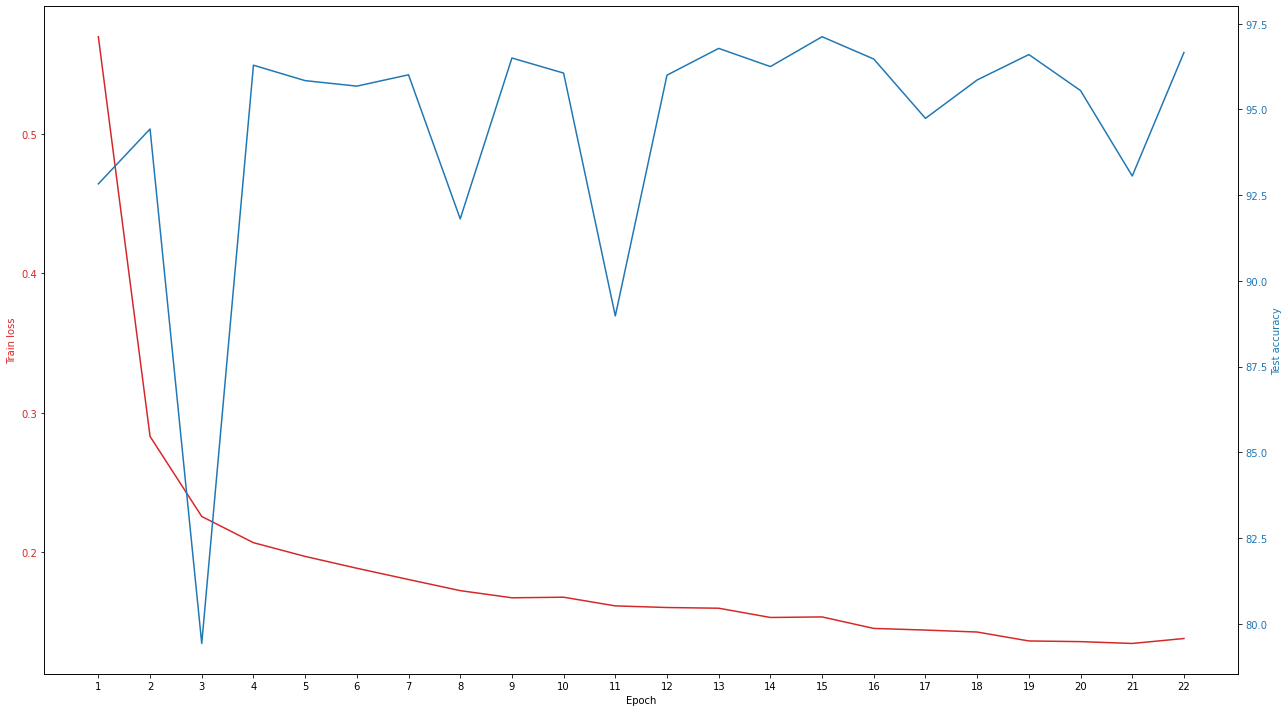

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_22.pth
Train Epoch: 23 [0/60000 (0%)]	Loss: 0.159262
Train Epoch: 23 [6400/60000 (11%)]	Loss: 0.195749
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.153029
Train Epoch: 23 [19200/60000 (32%)]	Loss: 0.086148
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.198084
Train Epoch: 23 [32000/60000 (53%)]	Loss: 0.046114
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.050975
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.203397
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.044411
Train Epoch: 23 [57600/60000 (96%)]	Loss: 0.068170

Test set: Average loss: 0.0001, Accuracy: 9689/10000 (97%)

[0.15926195681095123, 0.05654957517981529, 0.10383568704128265, 0.19956673681735992, 0.03567919880151749, 0.07348036766052246, 0.04992320016026497, 0.11041353642940521, 0.0780474916100502, 0.07425713539123535, 0.16914348304271698, 0.16920006275177002, 0.15743285417556763, 0.2023657262325287, 0.049062322825193405, 0.14513368904590607, 0.12260019779205322, 0

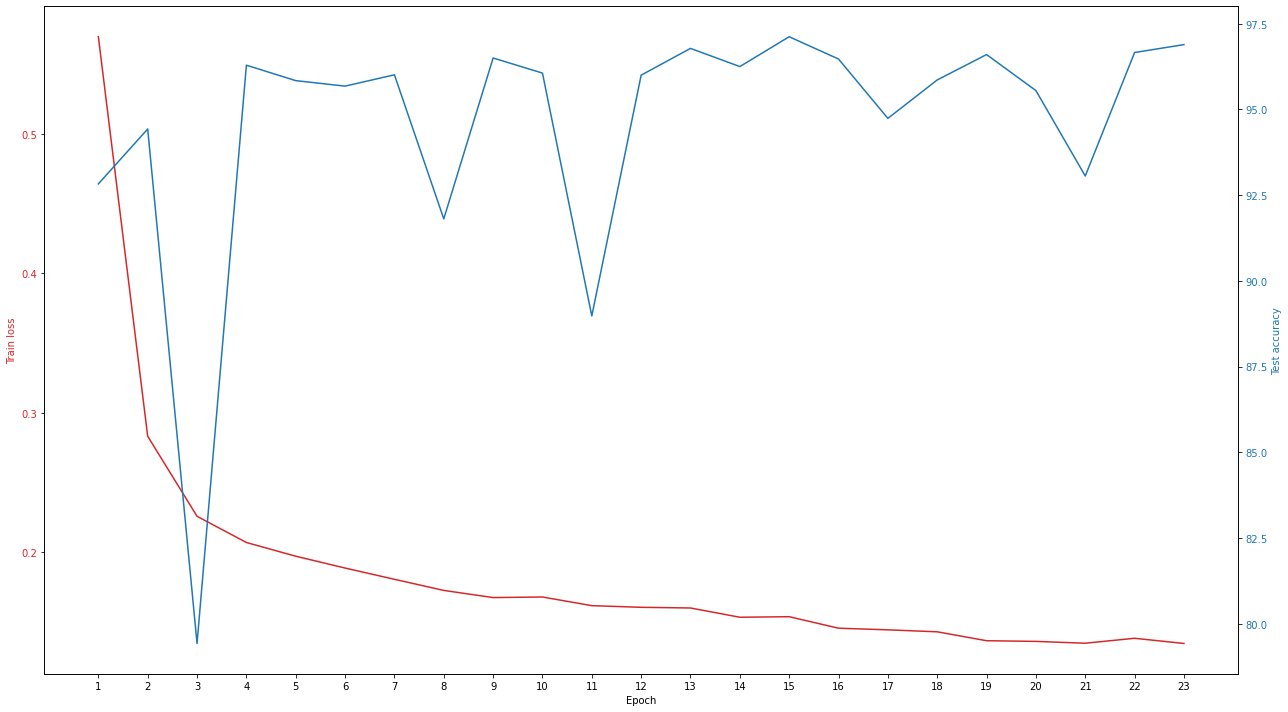

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_23.pth
Train Epoch: 24 [0/60000 (0%)]	Loss: 0.293342
Train Epoch: 24 [6400/60000 (11%)]	Loss: 0.240608
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.149971
Train Epoch: 24 [19200/60000 (32%)]	Loss: 0.233194
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.075126
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.134884
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.131895
Train Epoch: 24 [44800/60000 (75%)]	Loss: 0.181716
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.078606
Train Epoch: 24 [57600/60000 (96%)]	Loss: 0.117199

Test set: Average loss: 0.0005, Accuracy: 8489/10000 (85%)

[0.2933415174484253, 0.1408928632736206, 0.07440822571516037, 0.12198402732610703, 0.054688941687345505, 0.10823868215084076, 0.10692470520734787, 0.22259347140789032, 0.05173837020993233, 0.1799549013376236, 0.06521624326705933, 0.06997689604759216, 0.1311064064502716, 0.14860066771507263, 0.09373344480991364, 0.13413353264331818, 0.11374106258153915, 0.1

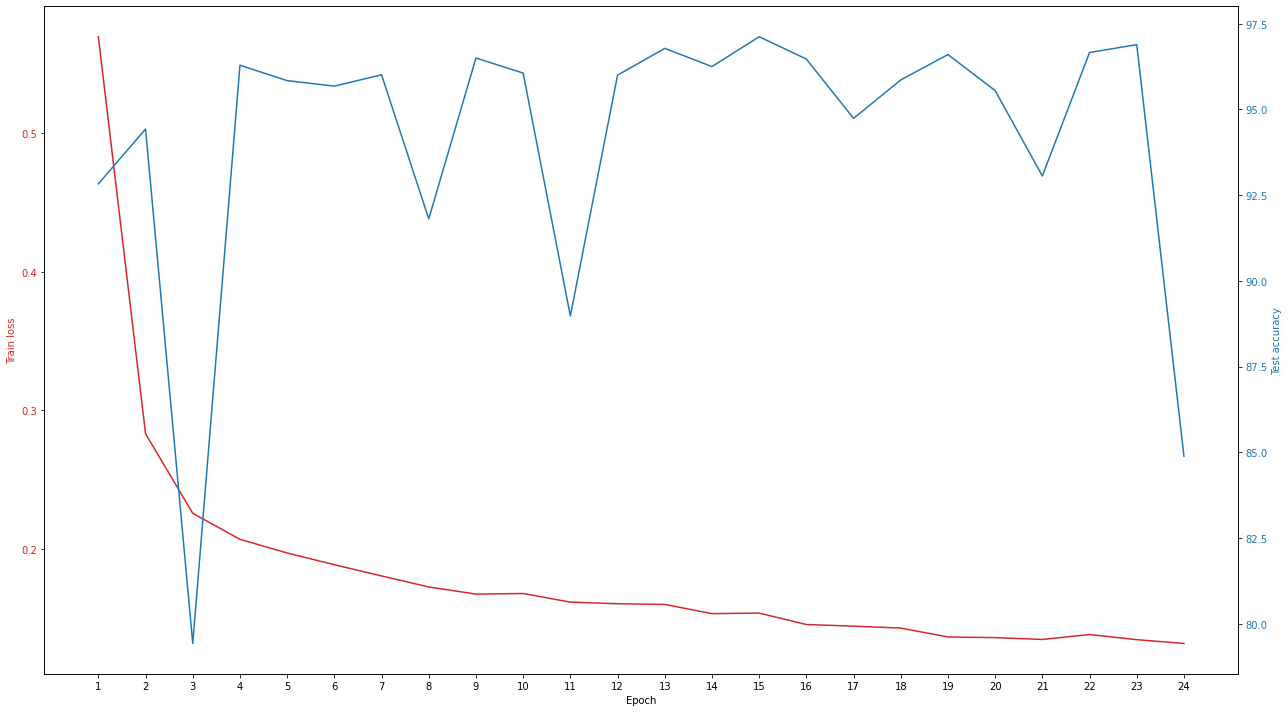

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_24.pth
Train Epoch: 25 [0/60000 (0%)]	Loss: 0.113553
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.199012
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.080433
Train Epoch: 25 [19200/60000 (32%)]	Loss: 0.147123
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.172378
Train Epoch: 25 [32000/60000 (53%)]	Loss: 0.222975
Train Epoch: 25 [38400/60000 (64%)]	Loss: 0.040820
Train Epoch: 25 [44800/60000 (75%)]	Loss: 0.145862
Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.018537
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.058581

Test set: Average loss: 0.0001, Accuracy: 9665/10000 (97%)

[0.11355310678482056, 0.3225577175617218, 0.03990408778190613, 0.03293977677822113, 0.05371515825390816, 0.1362701654434204, 0.11696702986955643, 0.046922363340854645, 0.20613883435726166, 0.14394624531269073, 0.10939948260784149, 0.038388416171073914, 0.05673544853925705, 0.12099876254796982, 0.16463804244995117, 0.09267482906579971, 0.1308722048997879, 0

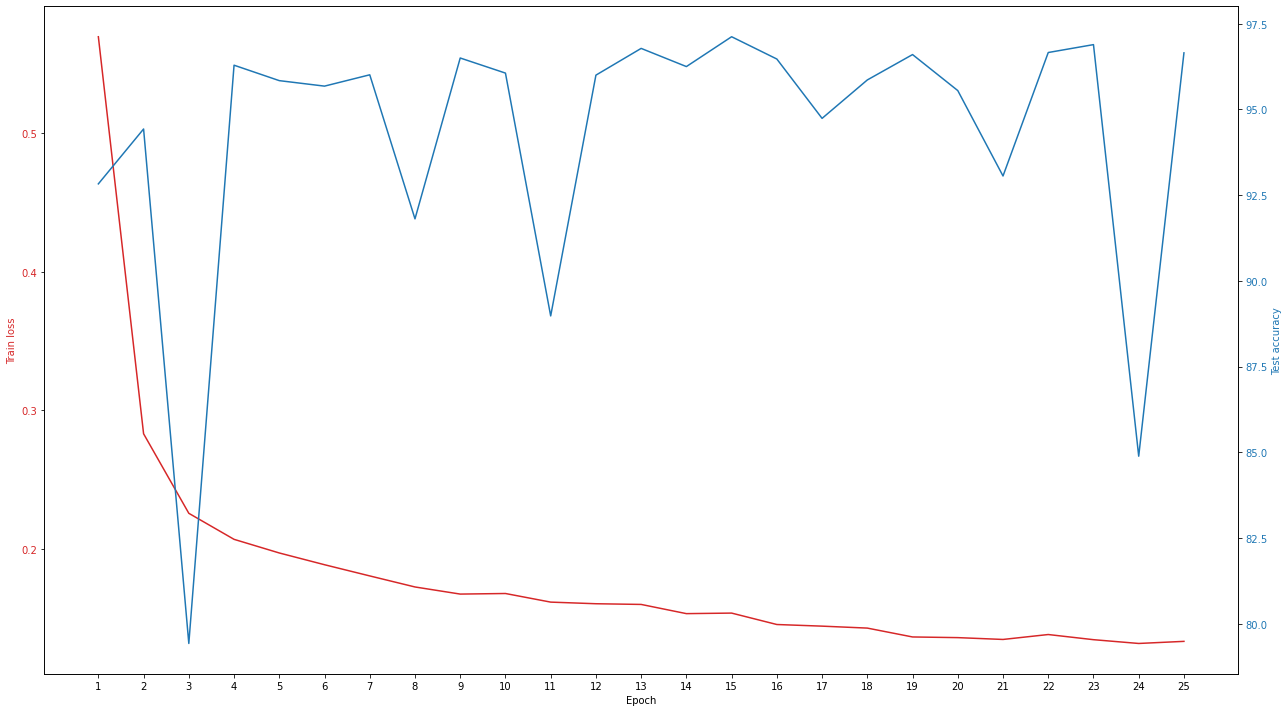

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_25.pth
Train Epoch: 26 [0/60000 (0%)]	Loss: 0.062958
Train Epoch: 26 [6400/60000 (11%)]	Loss: 0.039916
Train Epoch: 26 [12800/60000 (21%)]	Loss: 0.154658
Train Epoch: 26 [19200/60000 (32%)]	Loss: 0.200176
Train Epoch: 26 [25600/60000 (43%)]	Loss: 0.077795
Train Epoch: 26 [32000/60000 (53%)]	Loss: 0.194771
Train Epoch: 26 [38400/60000 (64%)]	Loss: 0.133196
Train Epoch: 26 [44800/60000 (75%)]	Loss: 0.178932
Train Epoch: 26 [51200/60000 (85%)]	Loss: 0.069880
Train Epoch: 26 [57600/60000 (96%)]	Loss: 0.100892

Test set: Average loss: 0.0001, Accuracy: 9649/10000 (96%)

[0.06295838207006454, 0.05383531376719475, 0.11191575974225998, 0.04466543719172478, 0.1649223417043686, 0.07489588856697083, 0.12577980756759644, 0.15254050493240356, 0.3335683047771454, 0.06275760382413864, 0.14481347799301147, 0.06342261284589767, 0.26412251591682434, 0.18384581804275513, 0.04939159005880356, 0.17710749804973602, 0.15087594091892242, 0.

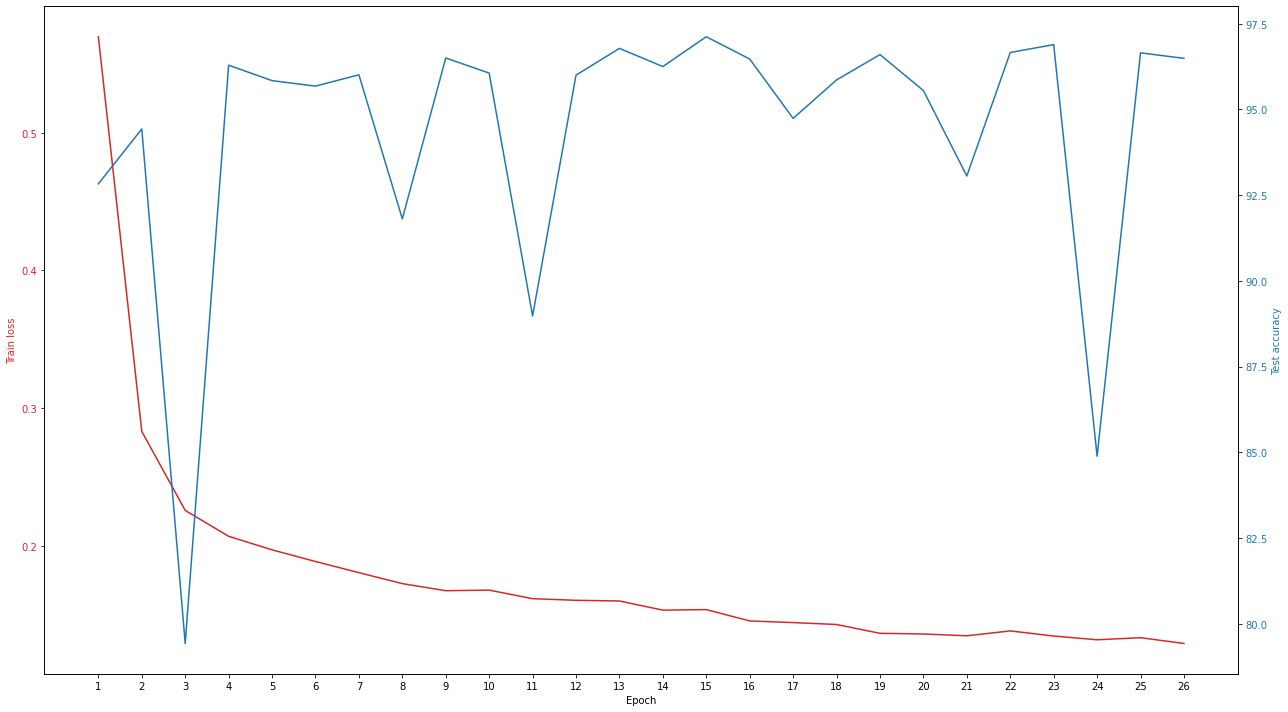

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_26.pth
Train Epoch: 27 [0/60000 (0%)]	Loss: 0.112763
Train Epoch: 27 [6400/60000 (11%)]	Loss: 0.174902
Train Epoch: 27 [12800/60000 (21%)]	Loss: 0.236855
Train Epoch: 27 [19200/60000 (32%)]	Loss: 0.139475
Train Epoch: 27 [25600/60000 (43%)]	Loss: 0.133152
Train Epoch: 27 [32000/60000 (53%)]	Loss: 0.129032
Train Epoch: 27 [38400/60000 (64%)]	Loss: 0.113335
Train Epoch: 27 [44800/60000 (75%)]	Loss: 0.113350
Train Epoch: 27 [51200/60000 (85%)]	Loss: 0.033895
Train Epoch: 27 [57600/60000 (96%)]	Loss: 0.170624

Test set: Average loss: 0.0002, Accuracy: 9339/10000 (93%)

[0.11276283115148544, 0.2174544334411621, 0.1898149847984314, 0.23146113753318787, 0.16281647980213165, 0.1344199776649475, 0.11752557754516602, 0.0769464448094368, 0.05214983597397804, 0.06523974984884262, 0.15344947576522827, 0.19326399266719818, 0.1678774058818817, 0.3579684793949127, 0.2389926165342331, 0.09457497298717499, 0.25349223613739014, 0.17510

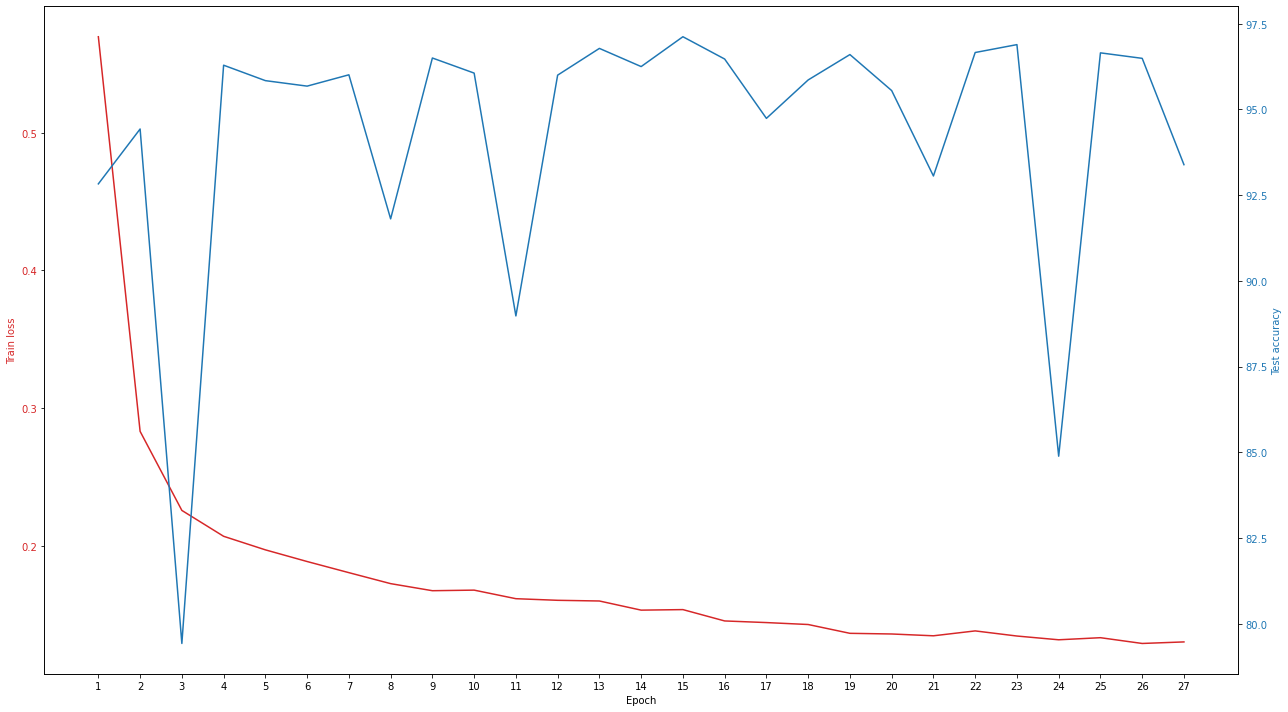

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_27.pth
Train Epoch: 28 [0/60000 (0%)]	Loss: 0.059521
Train Epoch: 28 [6400/60000 (11%)]	Loss: 0.145371
Train Epoch: 28 [12800/60000 (21%)]	Loss: 0.113750
Train Epoch: 28 [19200/60000 (32%)]	Loss: 0.238957
Train Epoch: 28 [25600/60000 (43%)]	Loss: 0.092682
Train Epoch: 28 [32000/60000 (53%)]	Loss: 0.077258
Train Epoch: 28 [38400/60000 (64%)]	Loss: 0.086706
Train Epoch: 28 [44800/60000 (75%)]	Loss: 0.215790
Train Epoch: 28 [51200/60000 (85%)]	Loss: 0.100517
Train Epoch: 28 [57600/60000 (96%)]	Loss: 0.081863

Test set: Average loss: 0.0001, Accuracy: 9679/10000 (97%)

[0.05952121689915657, 0.13048404455184937, 0.23675376176834106, 0.1440592110157013, 0.17879430949687958, 0.04617273434996605, 0.24162185192108154, 0.05552809312939644, 0.0924556776881218, 0.0430653877556324, 0.2489532232284546, 0.1414080560207367, 0.1965288668870926, 0.10149028897285461, 0.13138404488563538, 0.37027937173843384, 0.024940572679042816, 0.057

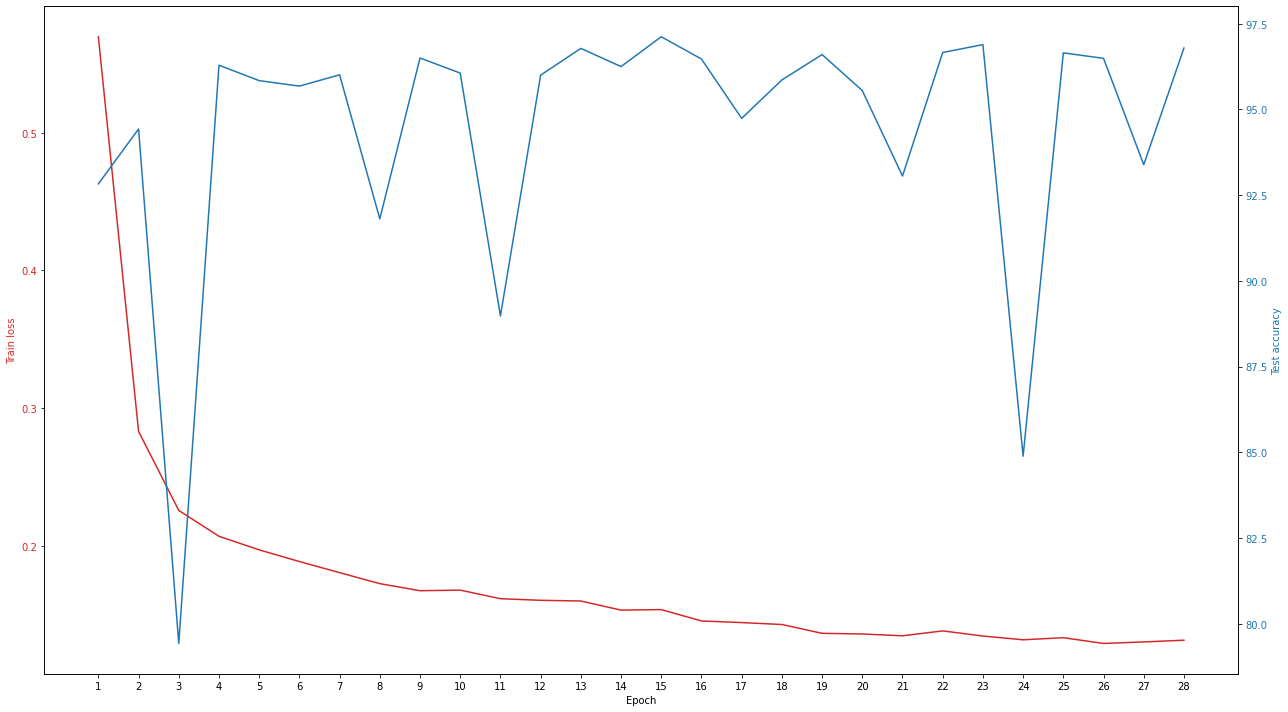

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_28.pth
Train Epoch: 29 [0/60000 (0%)]	Loss: 0.147035
Train Epoch: 29 [6400/60000 (11%)]	Loss: 0.252091
Train Epoch: 29 [12800/60000 (21%)]	Loss: 0.164456
Train Epoch: 29 [19200/60000 (32%)]	Loss: 0.218862
Train Epoch: 29 [25600/60000 (43%)]	Loss: 0.034814
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.086222
Train Epoch: 29 [38400/60000 (64%)]	Loss: 0.084921
Train Epoch: 29 [44800/60000 (75%)]	Loss: 0.123103
Train Epoch: 29 [51200/60000 (85%)]	Loss: 0.050145
Train Epoch: 29 [57600/60000 (96%)]	Loss: 0.200935

Test set: Average loss: 0.0002, Accuracy: 9535/10000 (95%)

[0.14703454077243805, 0.12729693949222565, 0.11481279134750366, 0.050531670451164246, 0.20258857309818268, 0.05760347843170166, 0.0740489736199379, 0.09707661718130112, 0.14489929378032684, 0.07746665179729462, 0.07900941371917725, 0.14970281720161438, 0.06144716590642929, 0.06365354359149933, 0.1276312917470932, 0.07958604395389557, 0.08476289361715317, 0

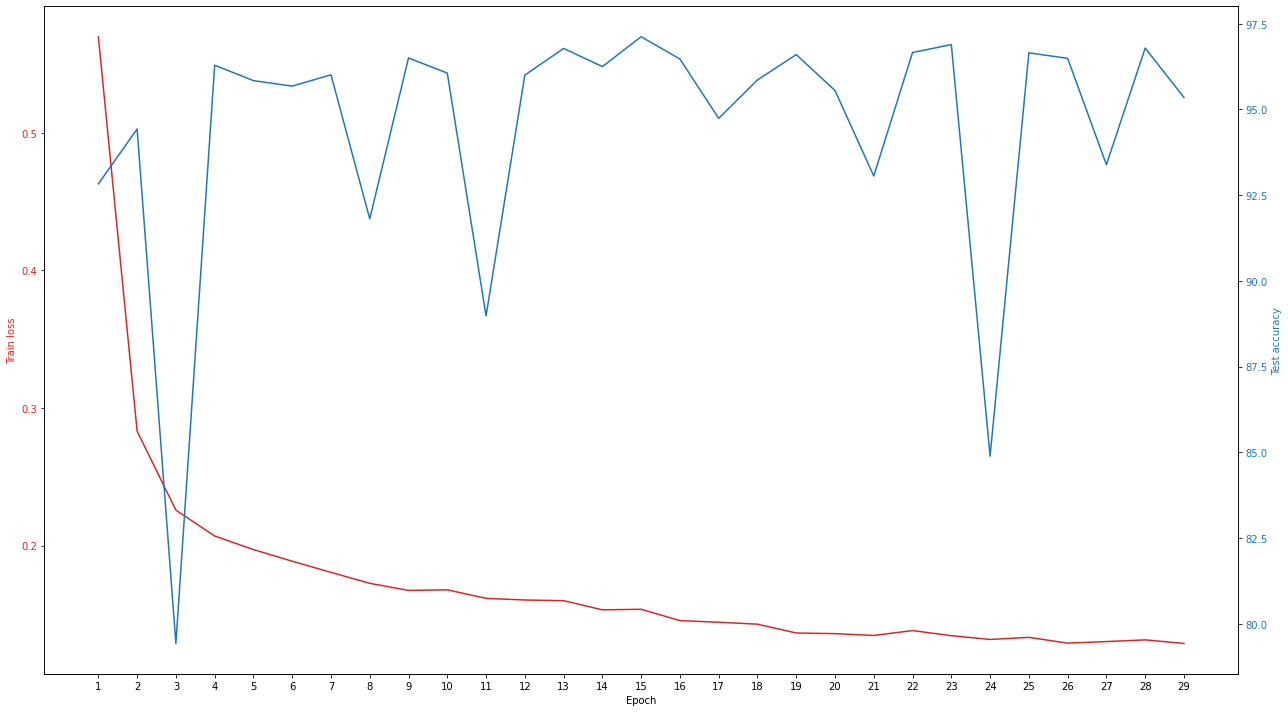

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_29.pth
Train Epoch: 30 [0/60000 (0%)]	Loss: 0.064027
Train Epoch: 30 [6400/60000 (11%)]	Loss: 0.141321
Train Epoch: 30 [12800/60000 (21%)]	Loss: 0.055821
Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.077366
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.105227
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.116958
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.169021
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.145587
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.112592
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.058982

Test set: Average loss: 0.0003, Accuracy: 9170/10000 (92%)

[0.0640270933508873, 0.2967548370361328, 0.18294163048267365, 0.06783399730920792, 0.06804407387971878, 0.08785970509052277, 0.037859927862882614, 0.16946697235107422, 0.1496405154466629, 0.28312504291534424, 0.20246796309947968, 0.034023333340883255, 0.17529764771461487, 0.13501308858394623, 0.15739737451076508, 0.18294811248779297, 0.06936956942081451, 0

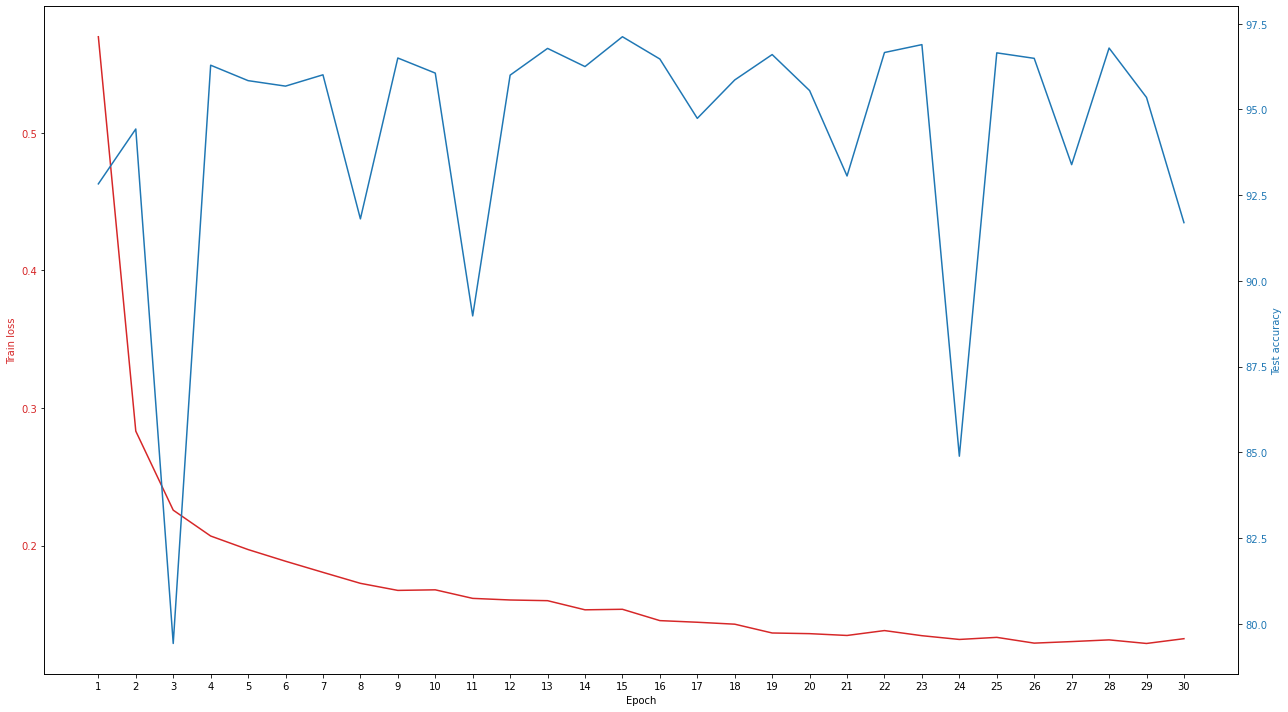

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/epoch_30.pth


In [96]:
test_accuracy_list = []
train_loss_list = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_accuracy = test()


    if epoch%40==0:
        optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

    x_axis = np.arange(1,epoch+1)
    test_accuracy_list.append(test_accuracy)
    train_loss_list.append(np.mean(train_loss))
    # plt.plot()
    print(train_loss)
    print(train_loss_list)
    
    fig, ax1 = plt.subplots()
    x_axis = np.arange(1,epoch+1,dtype=int)
    fig.set_size_inches(18,10)

    ax1.set_xticks(x_axis)
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train loss', color=color)
    ax1.plot(x_axis, train_loss_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Test accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(x_axis, test_accuracy_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    model_path = os.path.join(models_path,f"epoch_{epoch}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"saved model {model_path}")


In [97]:
best_epoch = np.argmax(test_accuracy_list)+1
best_epoch

15

In [98]:
model_path = os.path.join(models_path,f"epoch_{best_epoch}.pth")
model = Net()
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [102]:
model_path

'/shares/bulk/earapidis/saved_models/lenet_5/model_2/best.pth'

In [99]:
model_path = os.path.join(models_path,f"best.pth")
torch.save(model.state_dict(), model_path)
print(f"saved model {model_path}")

saved model /shares/bulk/earapidis/saved_models/lenet_5/model_2/best.pth
